# 0. Load Libraries & Data

In [58]:
import os
import pandas as pd
import numpy as np

import gc # 메모리 확보 필수

# EDA
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.font_manager as fm
import platform
import geopandas as gpd
import contextily as ctx  # 배경 지도 추가를 위한 라이브러리


In [59]:
# seed 설정
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [60]:
# 소수점 이하 3자리 반올림, 과학적 표기법 해제
pd.set_option('display.float_format', '{:.3f}'.format)
np.set_printoptions(suppress=True, precision=3)

In [61]:
# 파일 경로 설정
file_path = '../data/'

df = pd.read_csv(os.path.join(file_path, 'processed_data.csv'))

#### 위도, 경도를 기준으로 아파트 단지 ID 만들기

In [62]:
# 고유 아파트 단지 개수 구하기 (latitude, longitude의 조합)
unique_complexes = df[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)

# 고유한 ID 할당
unique_complexes['complex_id'] = unique_complexes.index

# 원본 df에 'complex_id' 추가
df = df.merge(unique_complexes, on=['latitude', 'longitude'], how='left')

# 고유한 아파트 단지 개수 출력
num_unique_complexes = unique_complexes.shape[0]
print(f"고유한 아파트 단지의 개수: {num_unique_complexes}")

고유한 아파트 단지의 개수: 18676


In [6]:
print(
    df.groupby('complex_id').agg({
    'deposit': 'mean',
    'area_m2': 'mean',
    'age': 'mean'
}).rename(columns={
    'deposit': 'complex_avg_deposit',
    'area_m2': 'complex_avg_area',
    'age': 'complex_avg_age'
})
)

            complex_avg_deposit  complex_avg_area  complex_avg_age
complex_id                                                        
0                     32814.685            85.208            3.141
1                      4750.000            59.340           34.000
2                      4750.000            59.833           26.083
3                     22475.379            90.706            5.124
4                      4635.616            41.770           31.276
...                         ...               ...              ...
18671                       NaN            79.400           21.000
18672                       NaN            64.100            9.000
18673                       NaN            75.620           20.000
18674                       NaN            49.900            9.000
18675                       NaN            84.940           18.000

[18676 rows x 3 columns]


#### 월별 거래 건수

In [63]:
# 월별 거래 건수 계산
monthly_transaction_counts = df.groupby('contract_year_month').size().reset_index(name='monthly_transaction_count')

df = df.merge(monthly_transaction_counts, on='contract_year_month', how='left')

In [64]:
# 계약 연도 및 월 추출
df['contract_year'] = df['contract_year_month'].astype(str).str[:4].astype(int)
df['contract_month'] = df['contract_year_month'].astype(str).str[4:6].astype(int)

# 계약 날짜 생성
df['contract_date'] = pd.to_datetime(df['contract_year_month'].astype(str) + df['contract_day'].astype(str), format='%Y%m%d')

# 계약 요일 추출 (0: 월요일, 6: 일요일)
df['contract_weekday'] = df['contract_date'].dt.weekday

### 메모리 확보

In [ ]:
def reduce_mem_usage(df):
    """
    Iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2  # Memory usage before optimization
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2  # Memory usage after optimization
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 394.53 MB
Memory usage after optimization is: 141.44 MB
Decreased by 64.2%


In [65]:
train_df = df.loc[df['_type'] == 'train'].drop('year_month_date', axis=1)
test_df = df.loc[df['_type'] == 'test'].drop('year_month_date', axis=1)

In [66]:
print(f'학습 데이터 크기: {train_df.shape}')
print(f'테스트 데이터 크기: {test_df.shape}')

학습 데이터 크기: (1801228, 26)
테스트 데이터 크기: (150172, 26)


In [ ]:
# 각 변수의 데이터 타입, 단위, 값의 범위, 유일 값 개수, 결측치 비율을 추출하는 함수
def describe_data(df):
    data_description = []
    
    for col in df.columns:
        col_data = {}
        col_data['변수명'] = col
        col_data['데이터 타입'] = df[col].dtype
        col_data['값의 범위'] = f"{df[col].min()} ~ {df[col].max()}" if df[col].dtype != 'object' else '범주형'
        col_data['값'] = df[col].unique()[:5]  # 처음 5개 값만 표시
        col_data['Uniq 값 개수'] = df[col].nunique()
        col_data['결측치'] = df[col].isnull().sum()
        
        data_description.append(col_data)
    
    return pd.DataFrame(data_description)

describe_data(df)

In [68]:
df['contract_date'] = df['contract_date'].astype(str)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1951400 entries, 0 to 1951399
Data columns (total 27 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   index                           int32  
 1   area_m2                         float16
 2   contract_year_month             int32  
 3   contract_day                    int8   
 4   contract_type                   int8   
 5   floor                           int8   
 6   built_year                      int16  
 7   latitude                        float16
 8   longitude                       float16
 9   age                             int8   
 10  deposit                         float32
 11  _type                           object 
 12  nearest_subway_distance_km      float16
 13  year_month_date                 object 
 14  interest_rate                   float16
 15  prev_month_interest_rate        float16
 16  nearest_elementary_distance_km  float16
 17  nearest_middle_distance_km 

In [72]:
gc.collect()

48355

# 1. EDA

## (1) 단변량 분석

### 연속형 변수

#### (a) 분포 확인

In [17]:
# 한글 폰트 사용시 마이너스 깨지는 문제 
matplotlib.rcParams['axes.unicode_minus'] = False

#폰트 경로
font_path = "/usr/share/fonts/NanumFont/NanumGothicBold.ttf"
 
#폰트 이름 얻어오기
font_name = fm.FontProperties(fname=font_path).get_name()

plt.rcParams["font.family"] = font_name
plt.rcParams["font.size"] = 15

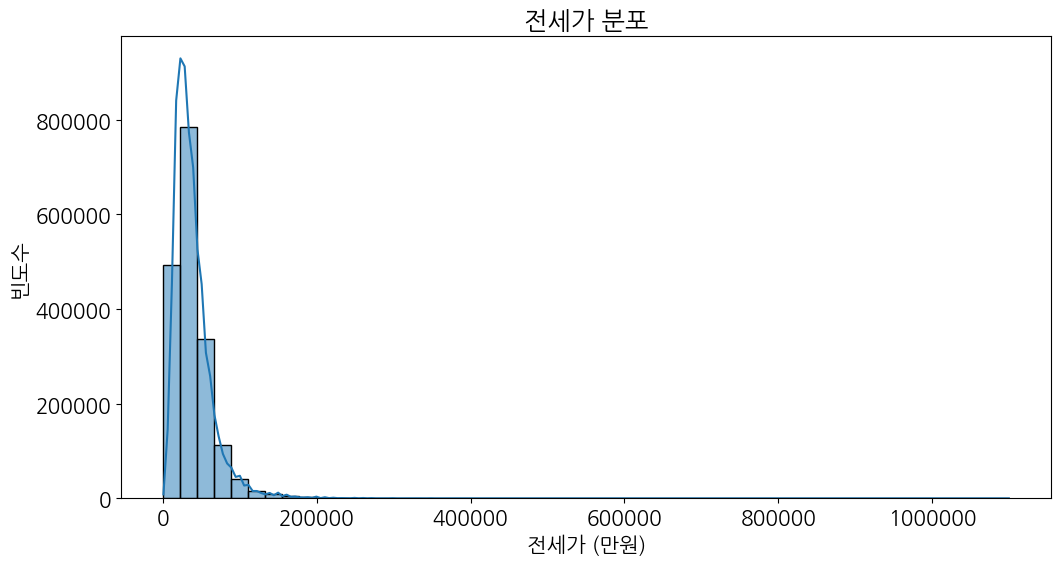

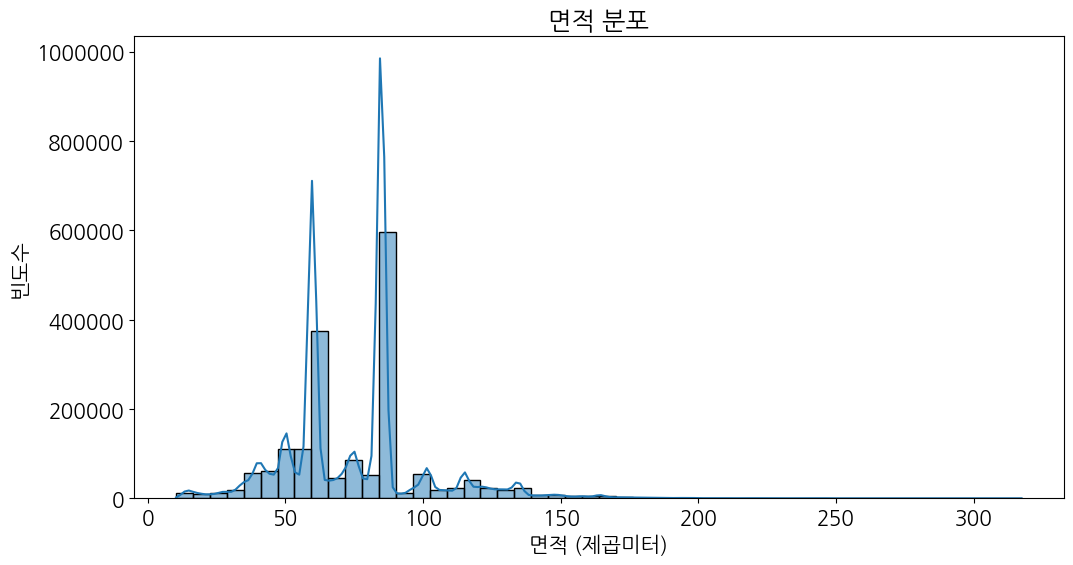

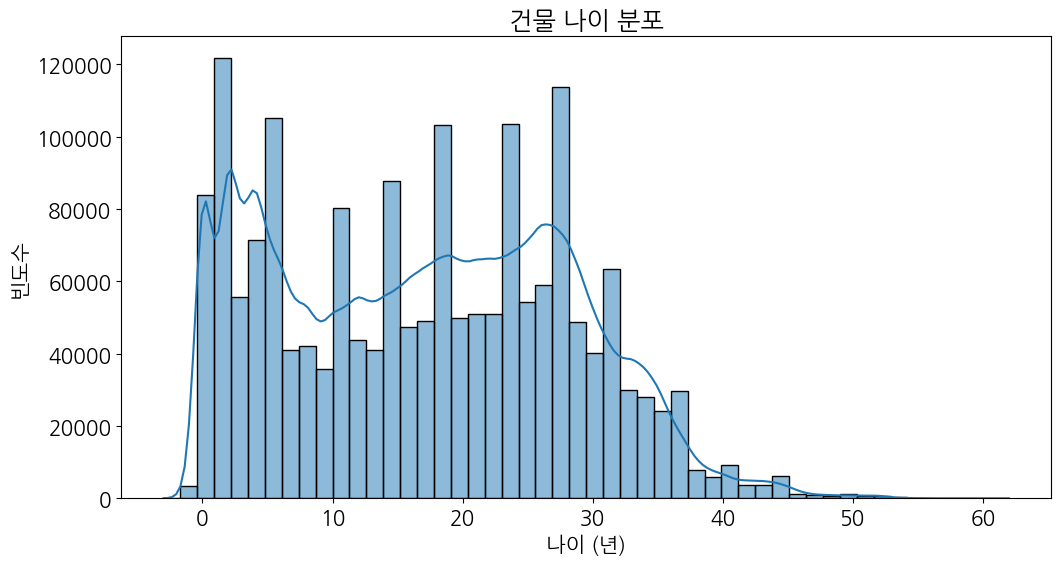

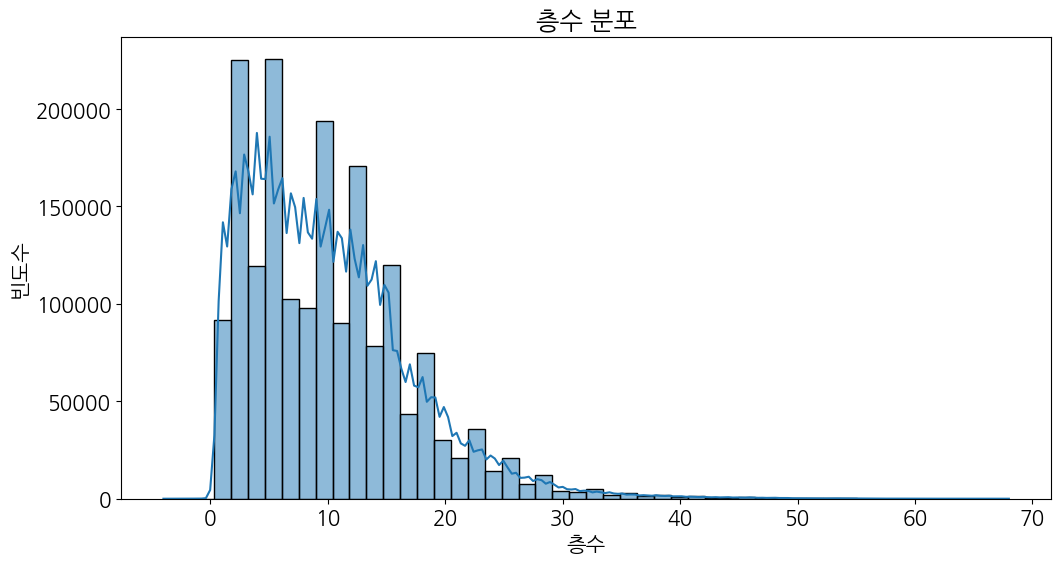

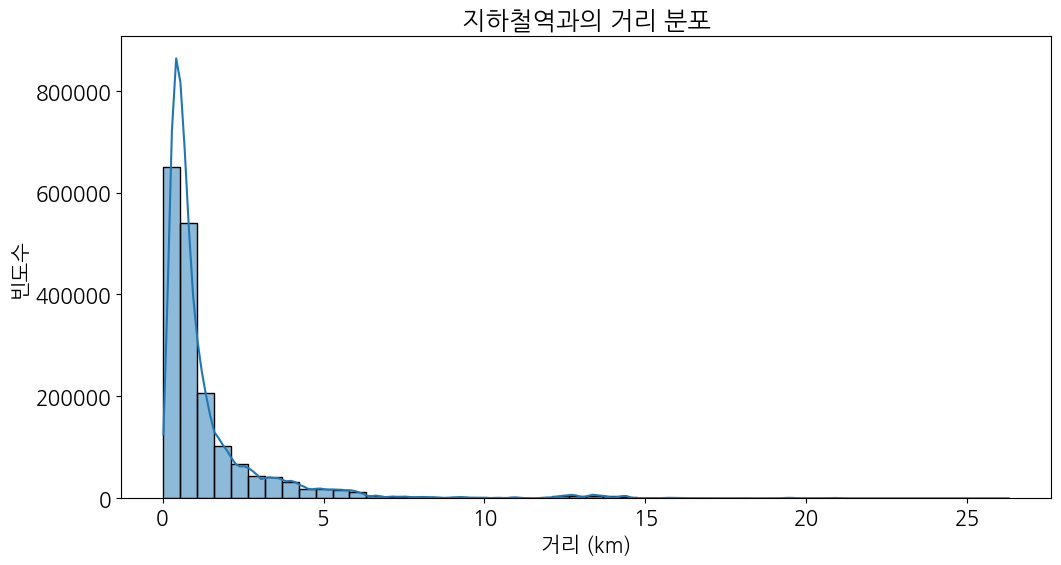

In [38]:
def plot_distribution(df, column, title, xlabel, bins=50):
    plt.figure(figsize=(12, 6))
    sns.histplot(df[column], kde=True, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('빈도수')
    
    # x축과 y축의 과학적 표기법을 일반 숫자 형식으로 변환
    plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())
    plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter())
    plt.gca().ticklabel_format(useOffset=False, style='plain', axis='both')
    plt.show()

# 각 변수에 대해 분포 확인
plot_distribution(train_df, 'deposit', '전세가 분포', '전세가 (만원)')
plot_distribution(train_df, 'area_m2', '면적 분포', '면적 (제곱미터)')
plot_distribution(train_df, 'age', '건물 나이 분포', '나이 (년)')
plot_distribution(train_df, 'floor', '층수 분포', '층수')
plot_distribution(train_df, 'nearest_subway_distance_km', '지하철역과의 거리 분포', '거리 (km)')


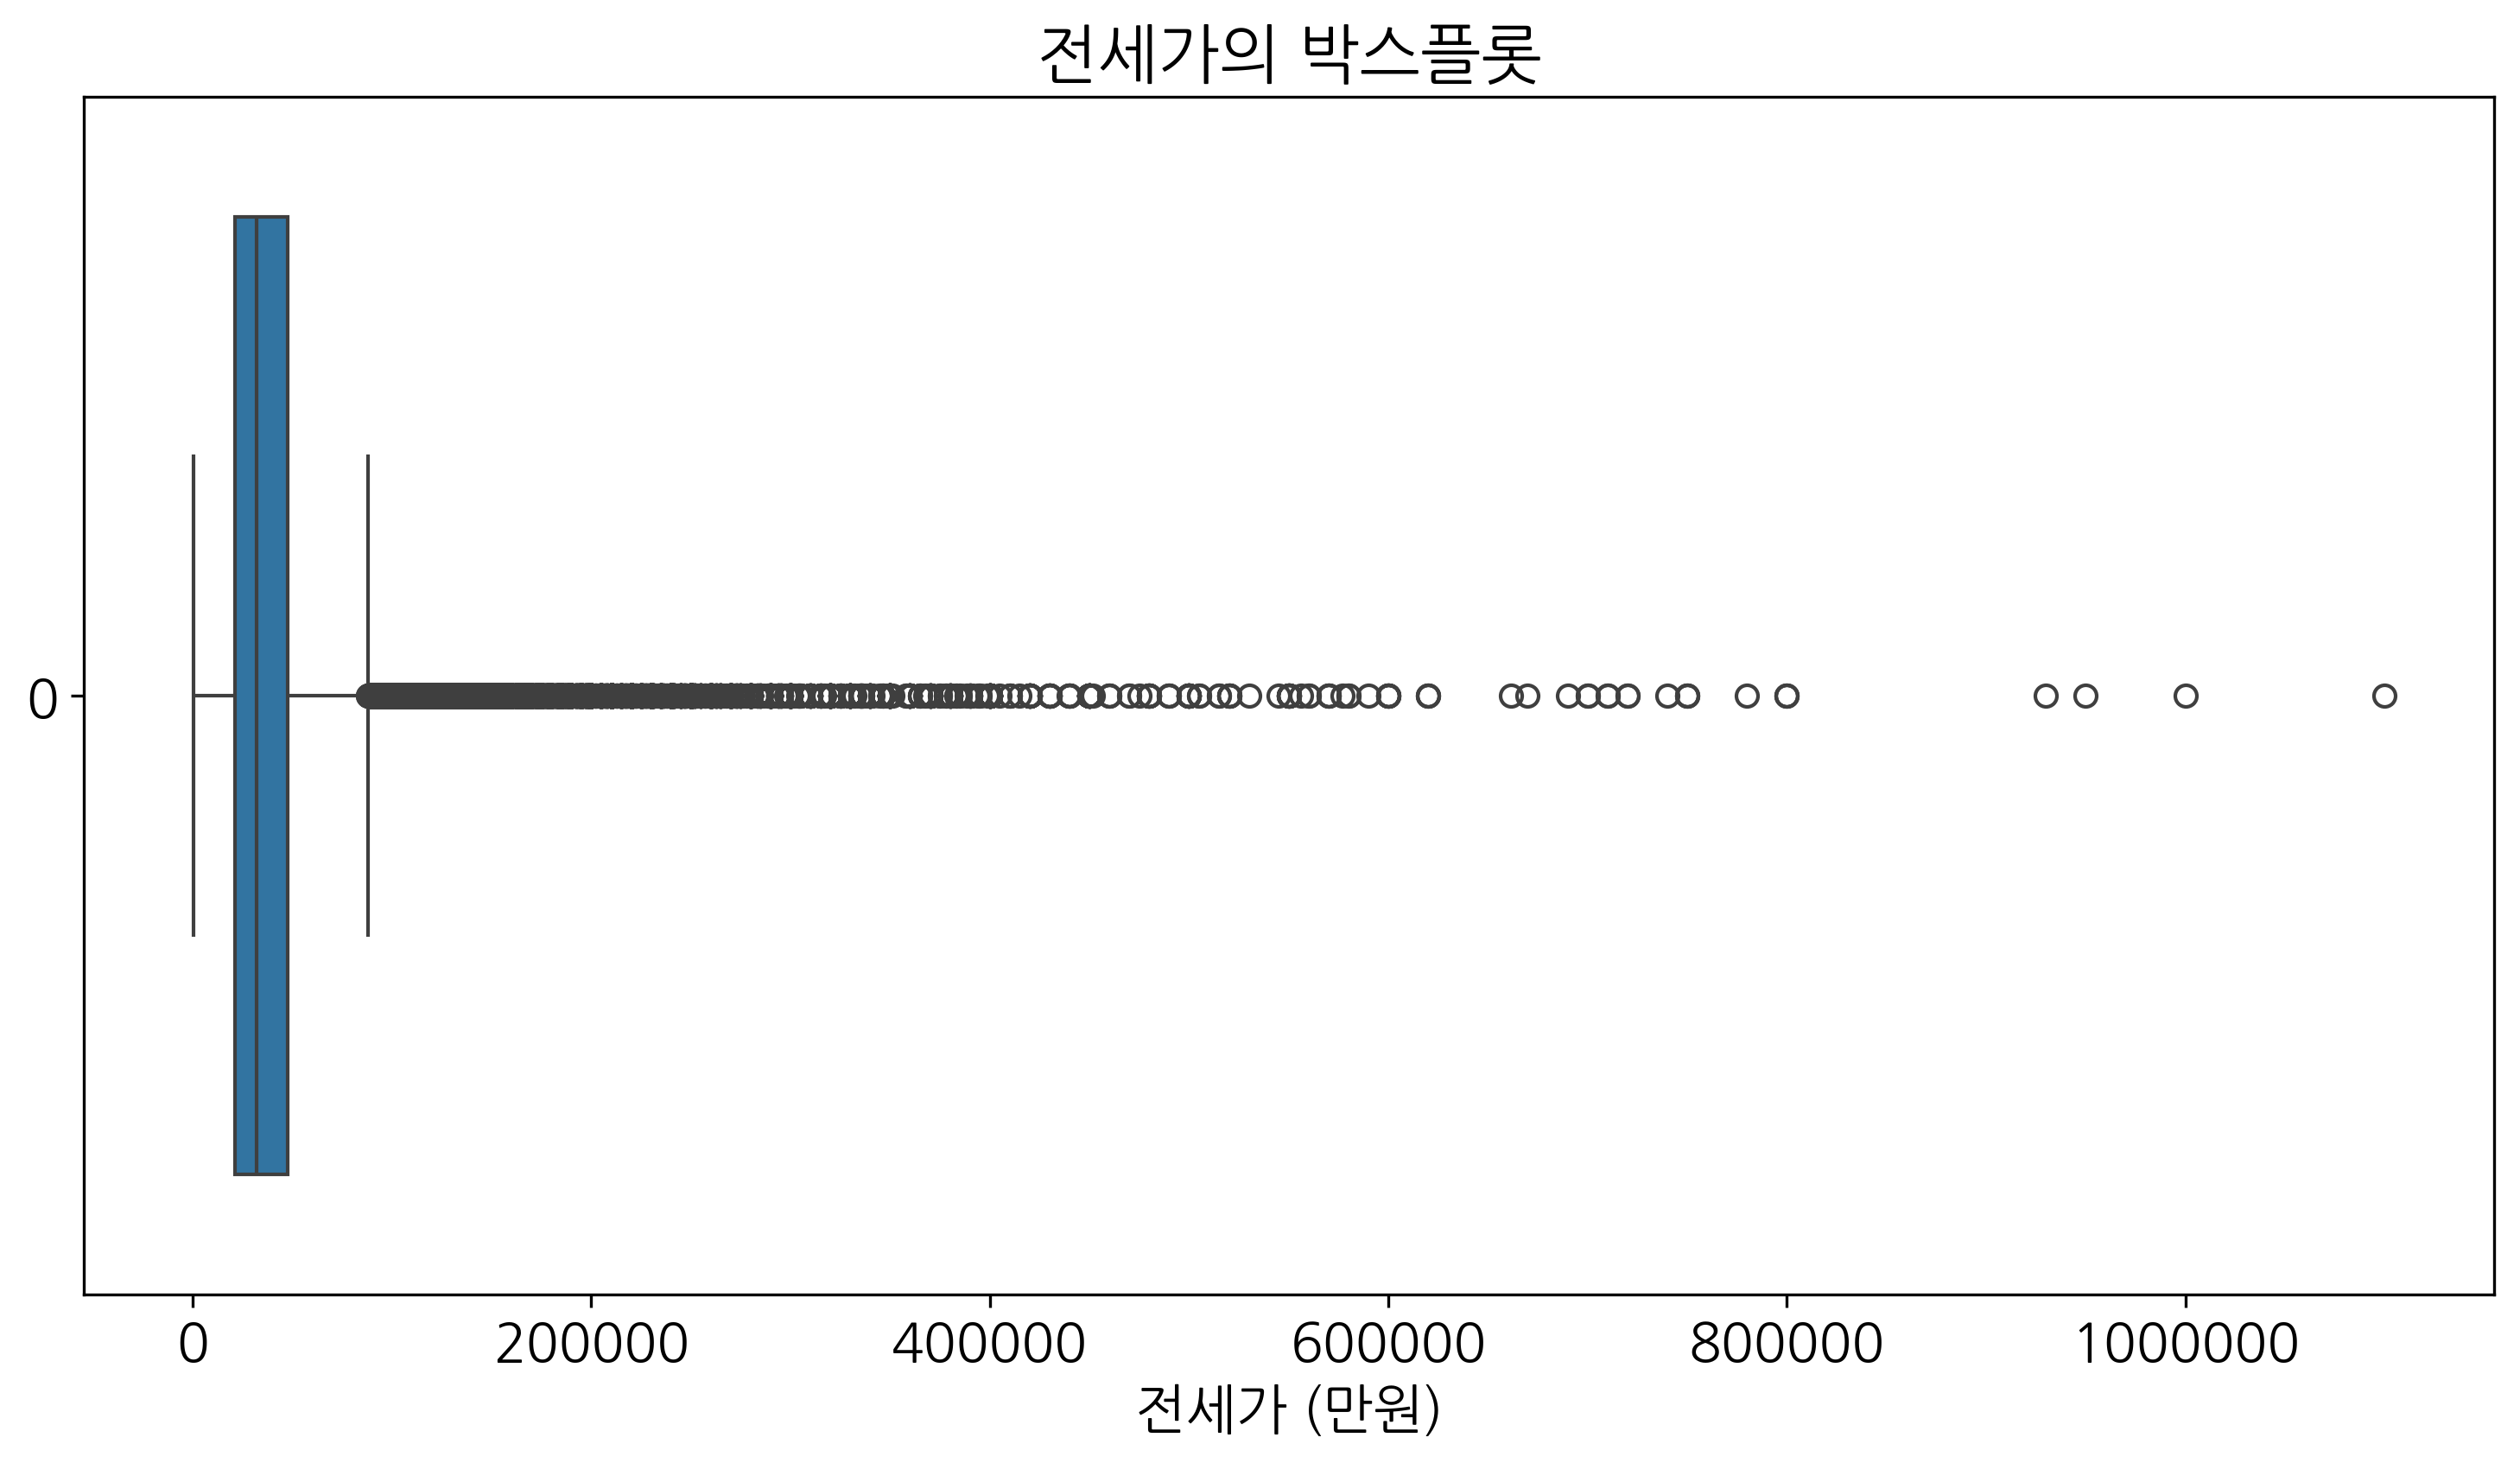

In [39]:
plt.figure(figsize=(12, 6), dpi=300)
sns.boxplot(x=train_df['deposit'])
plt.title('전세가의 박스플롯')
plt.xlabel('전세가 (만원)')

# x축과 y축의 과학적 표기법을 일반 숫자 형식으로 변환
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().ticklabel_format(useOffset=False, style='plain', axis='both')
plt.show()

### 범주형 변수

#### (a) 빈도 분석

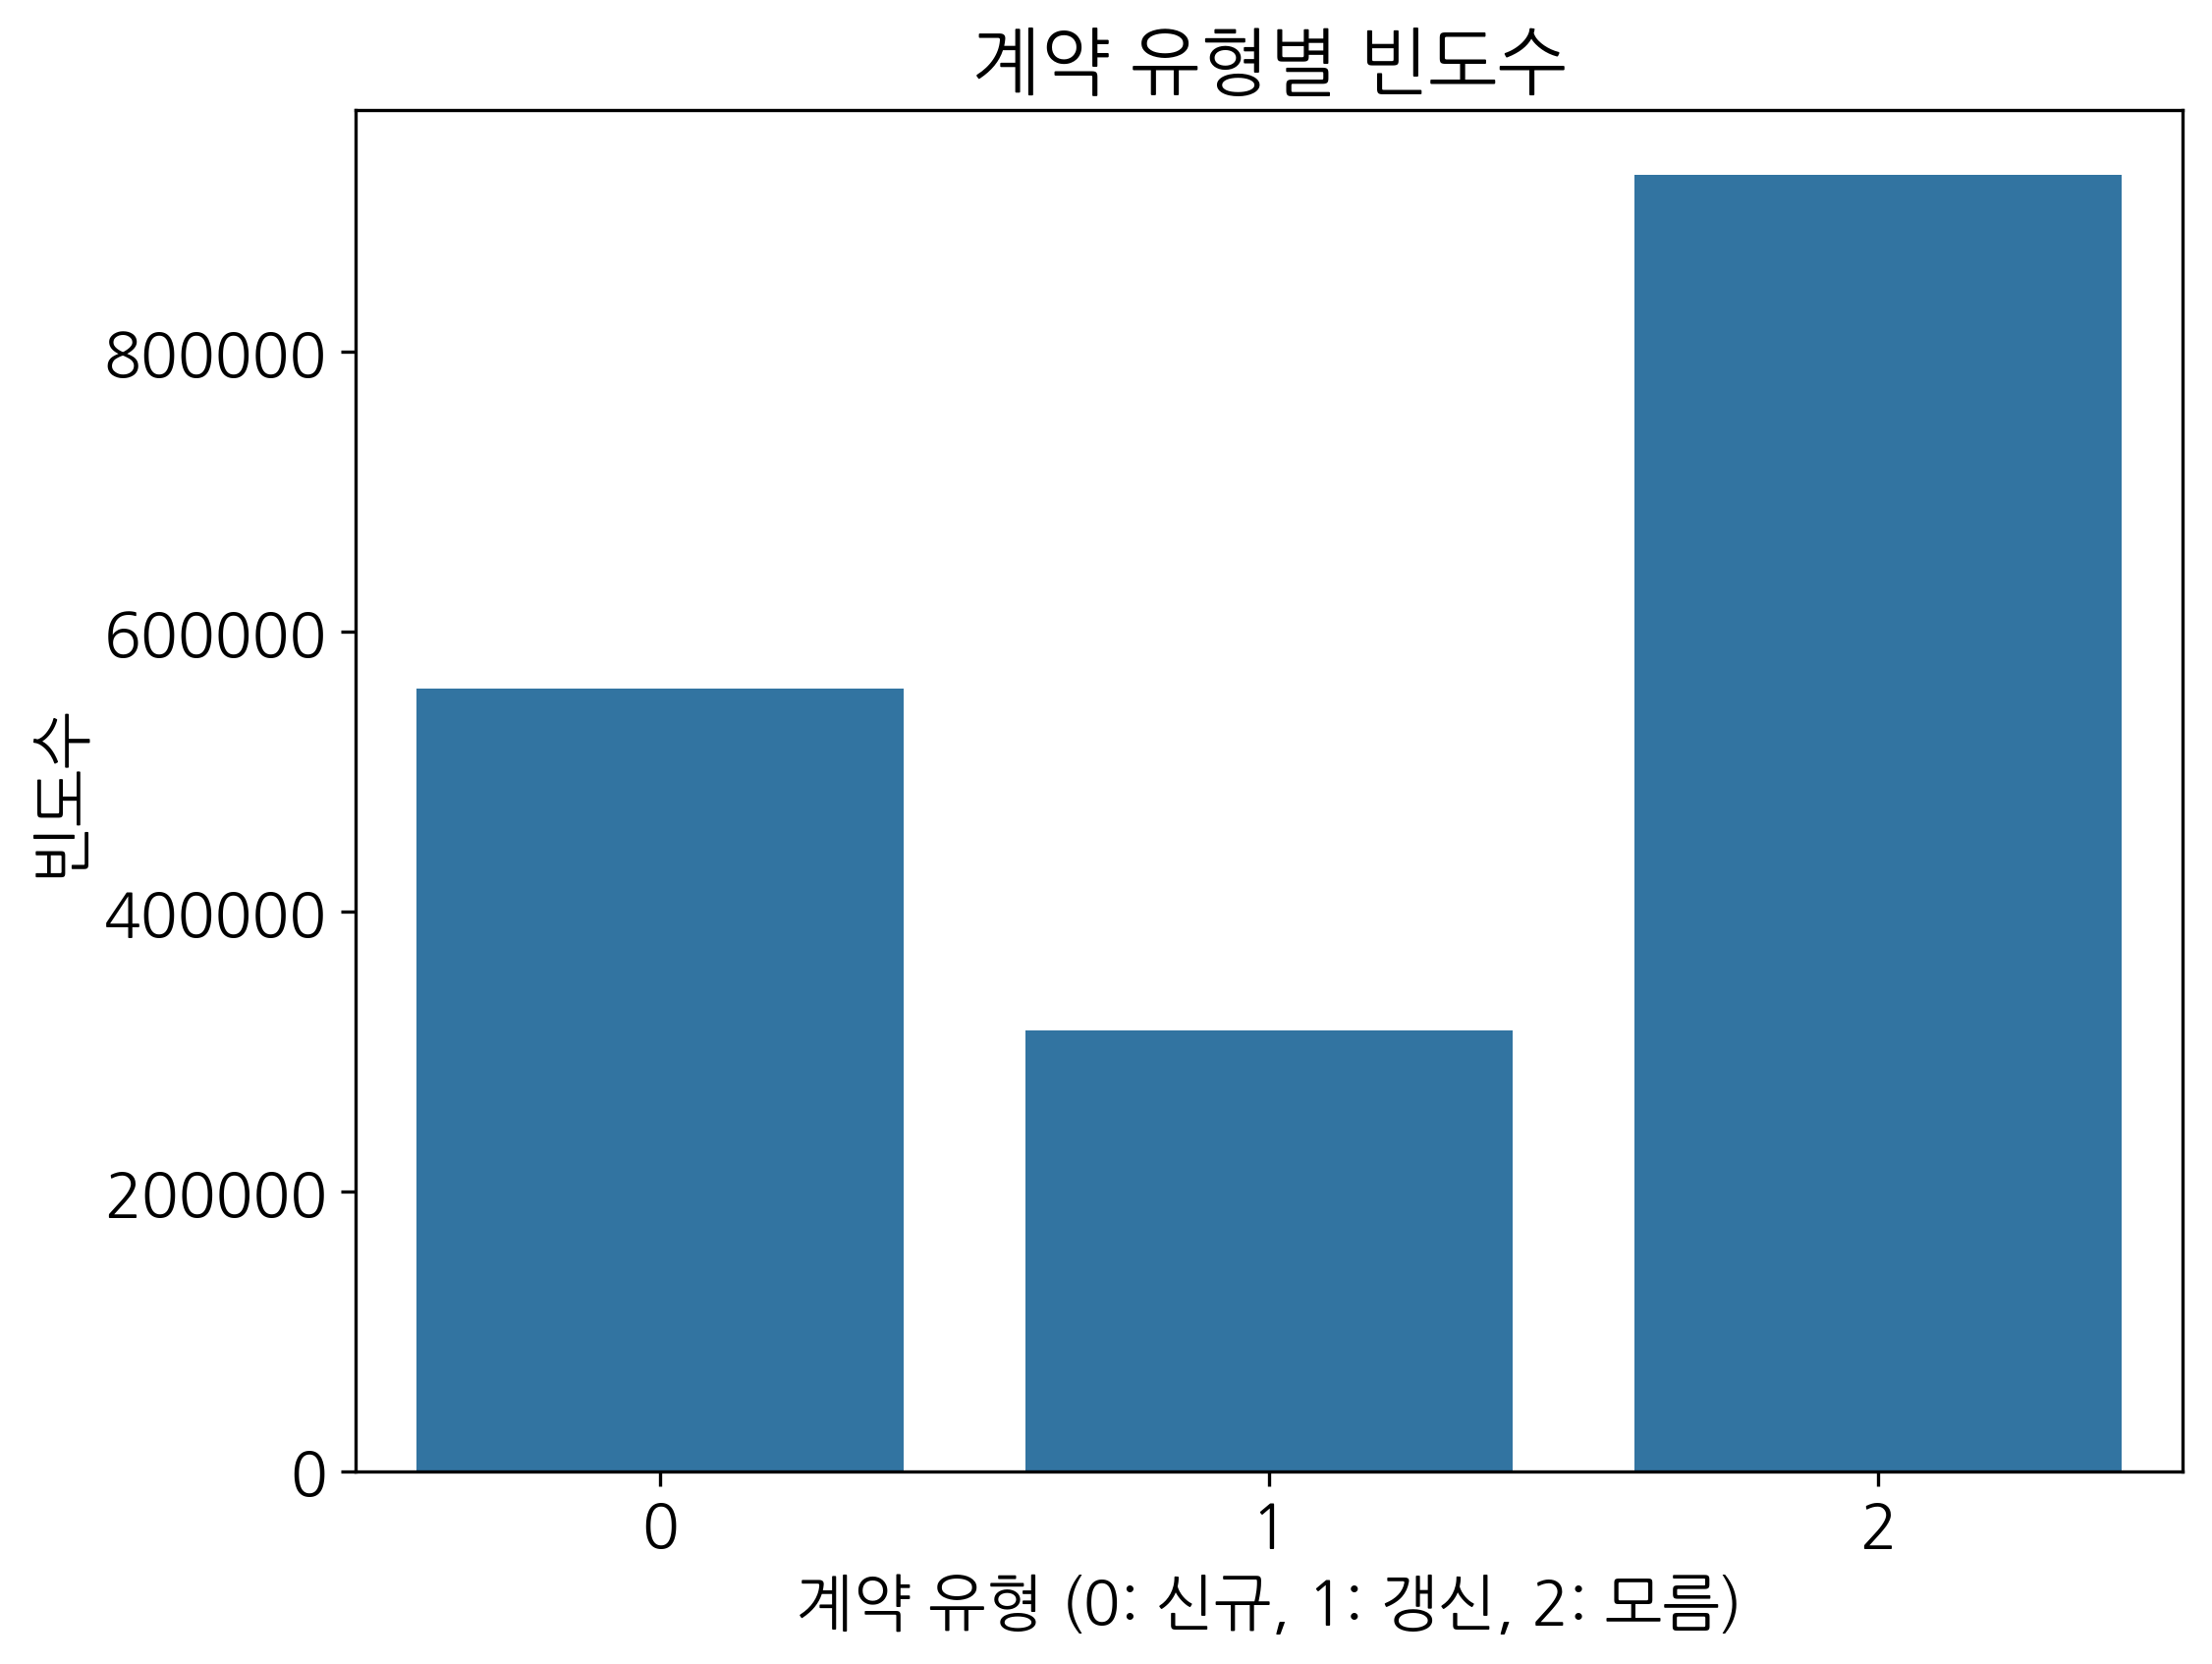

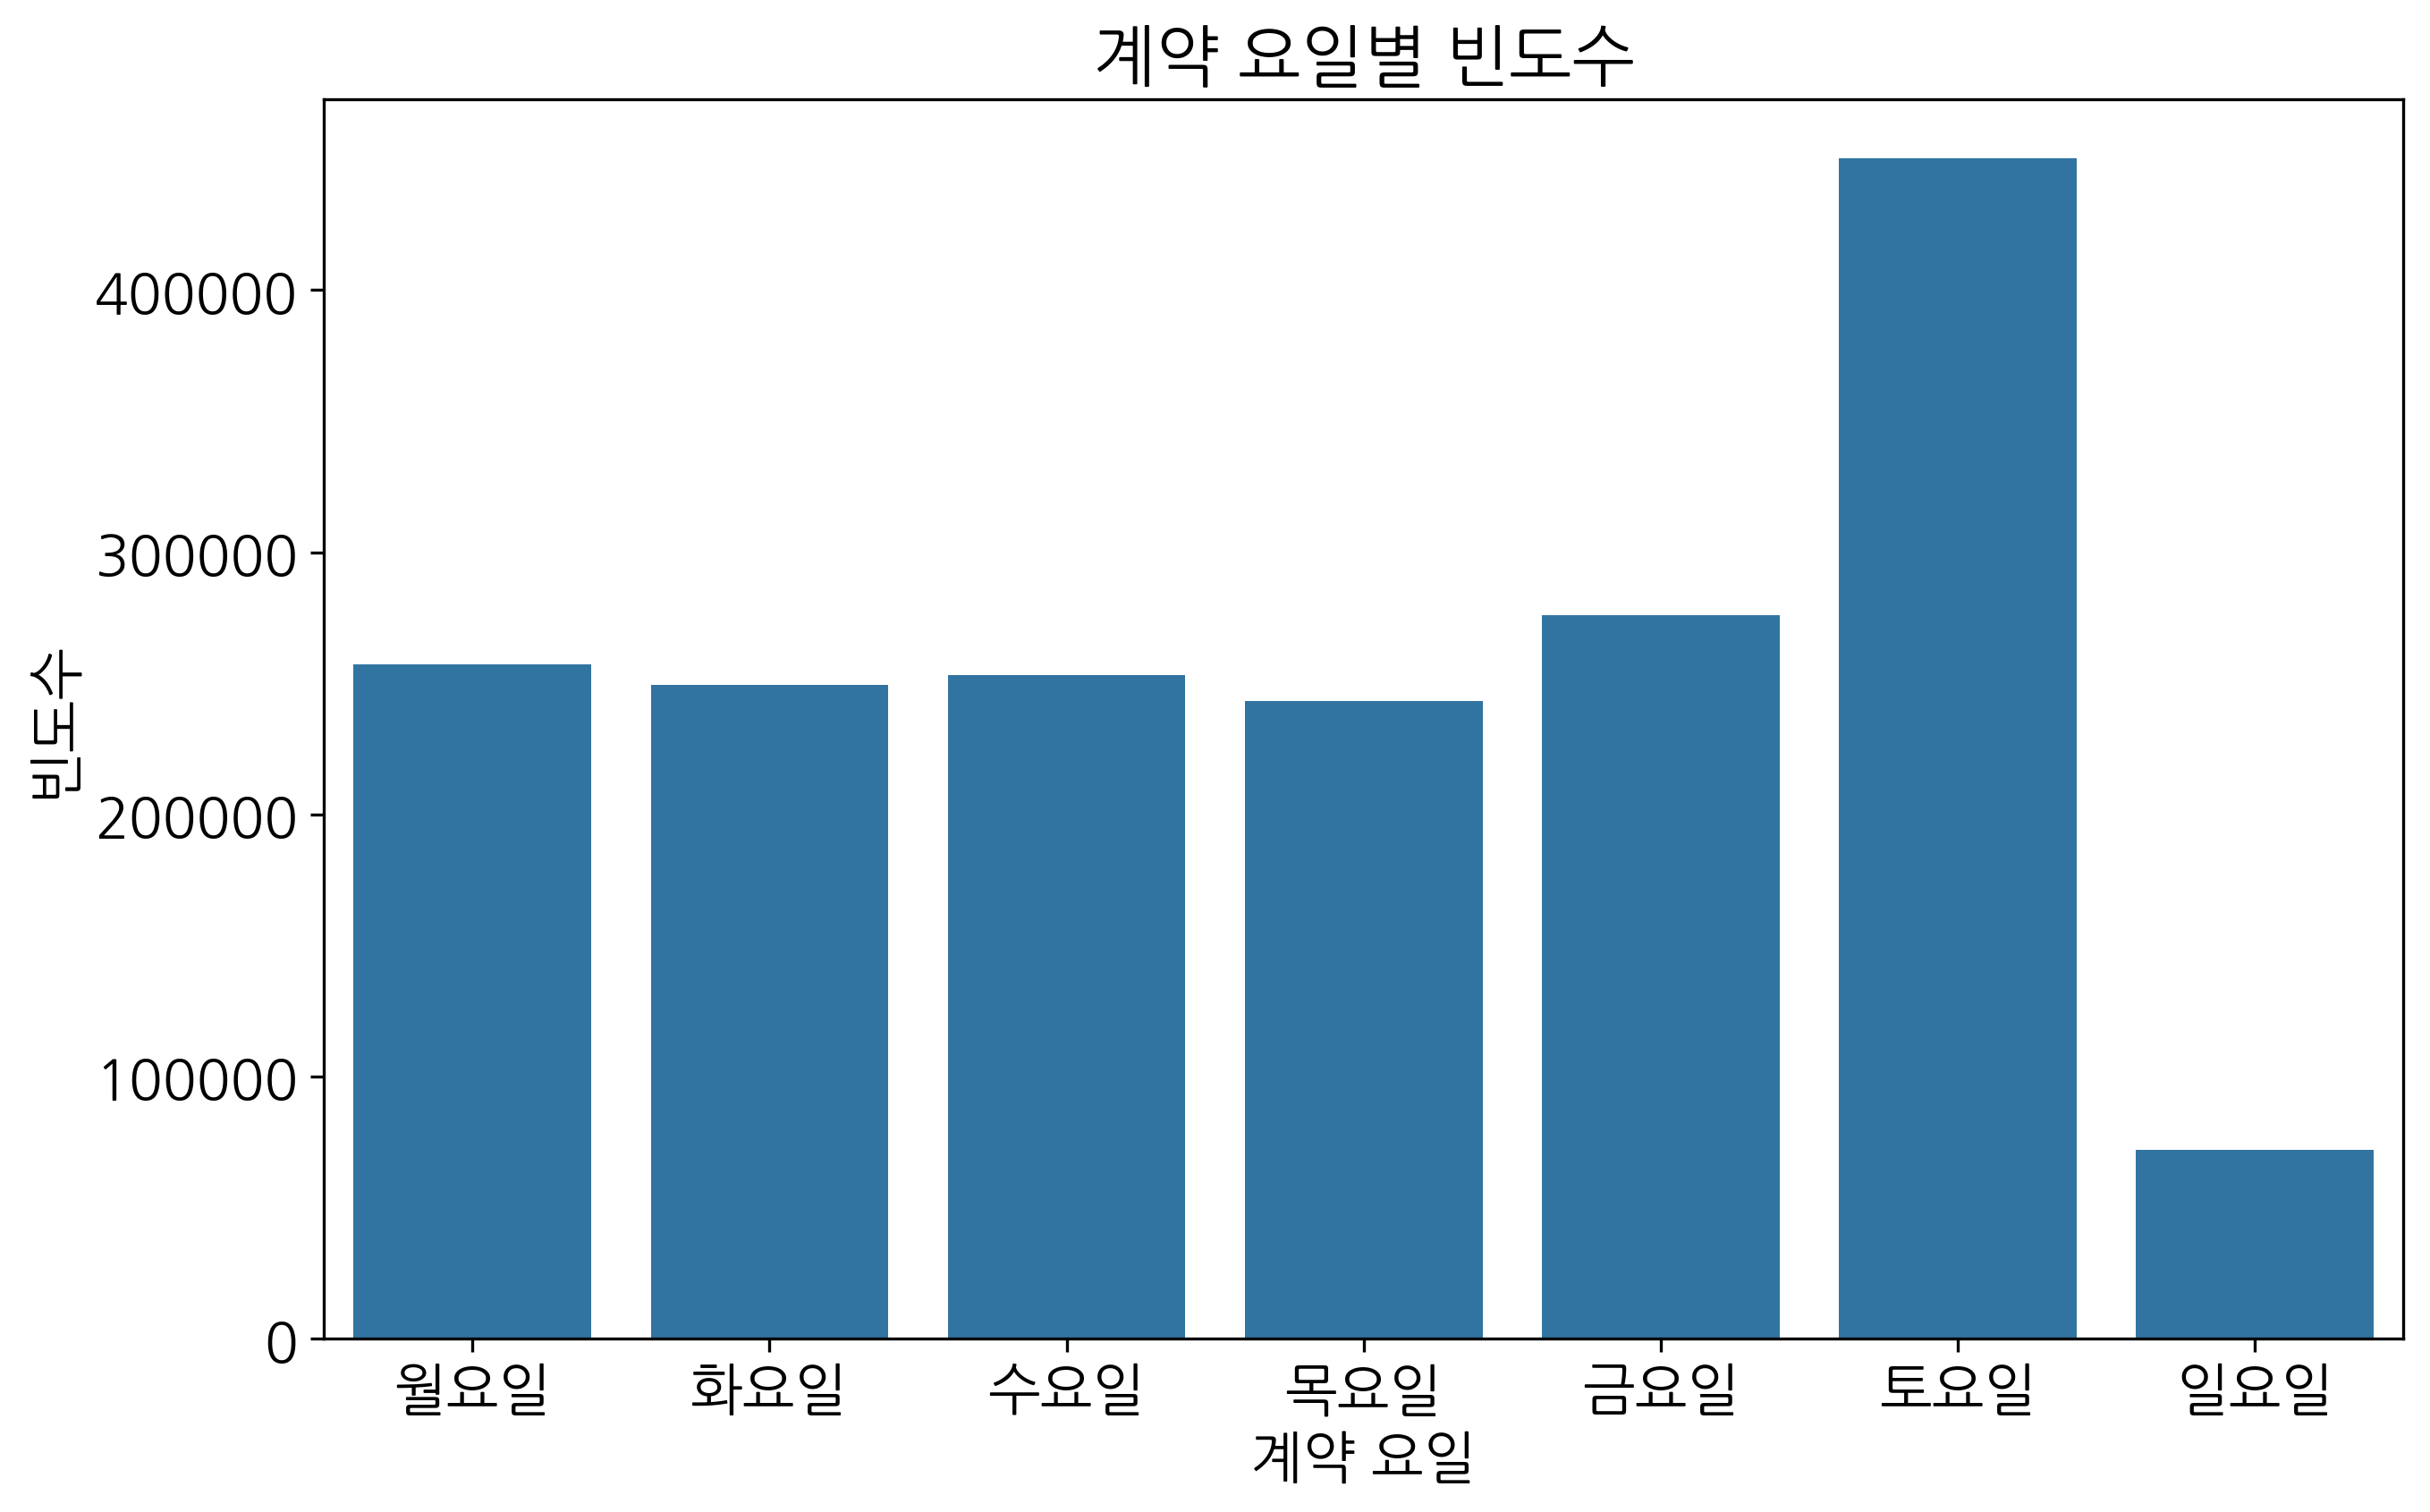

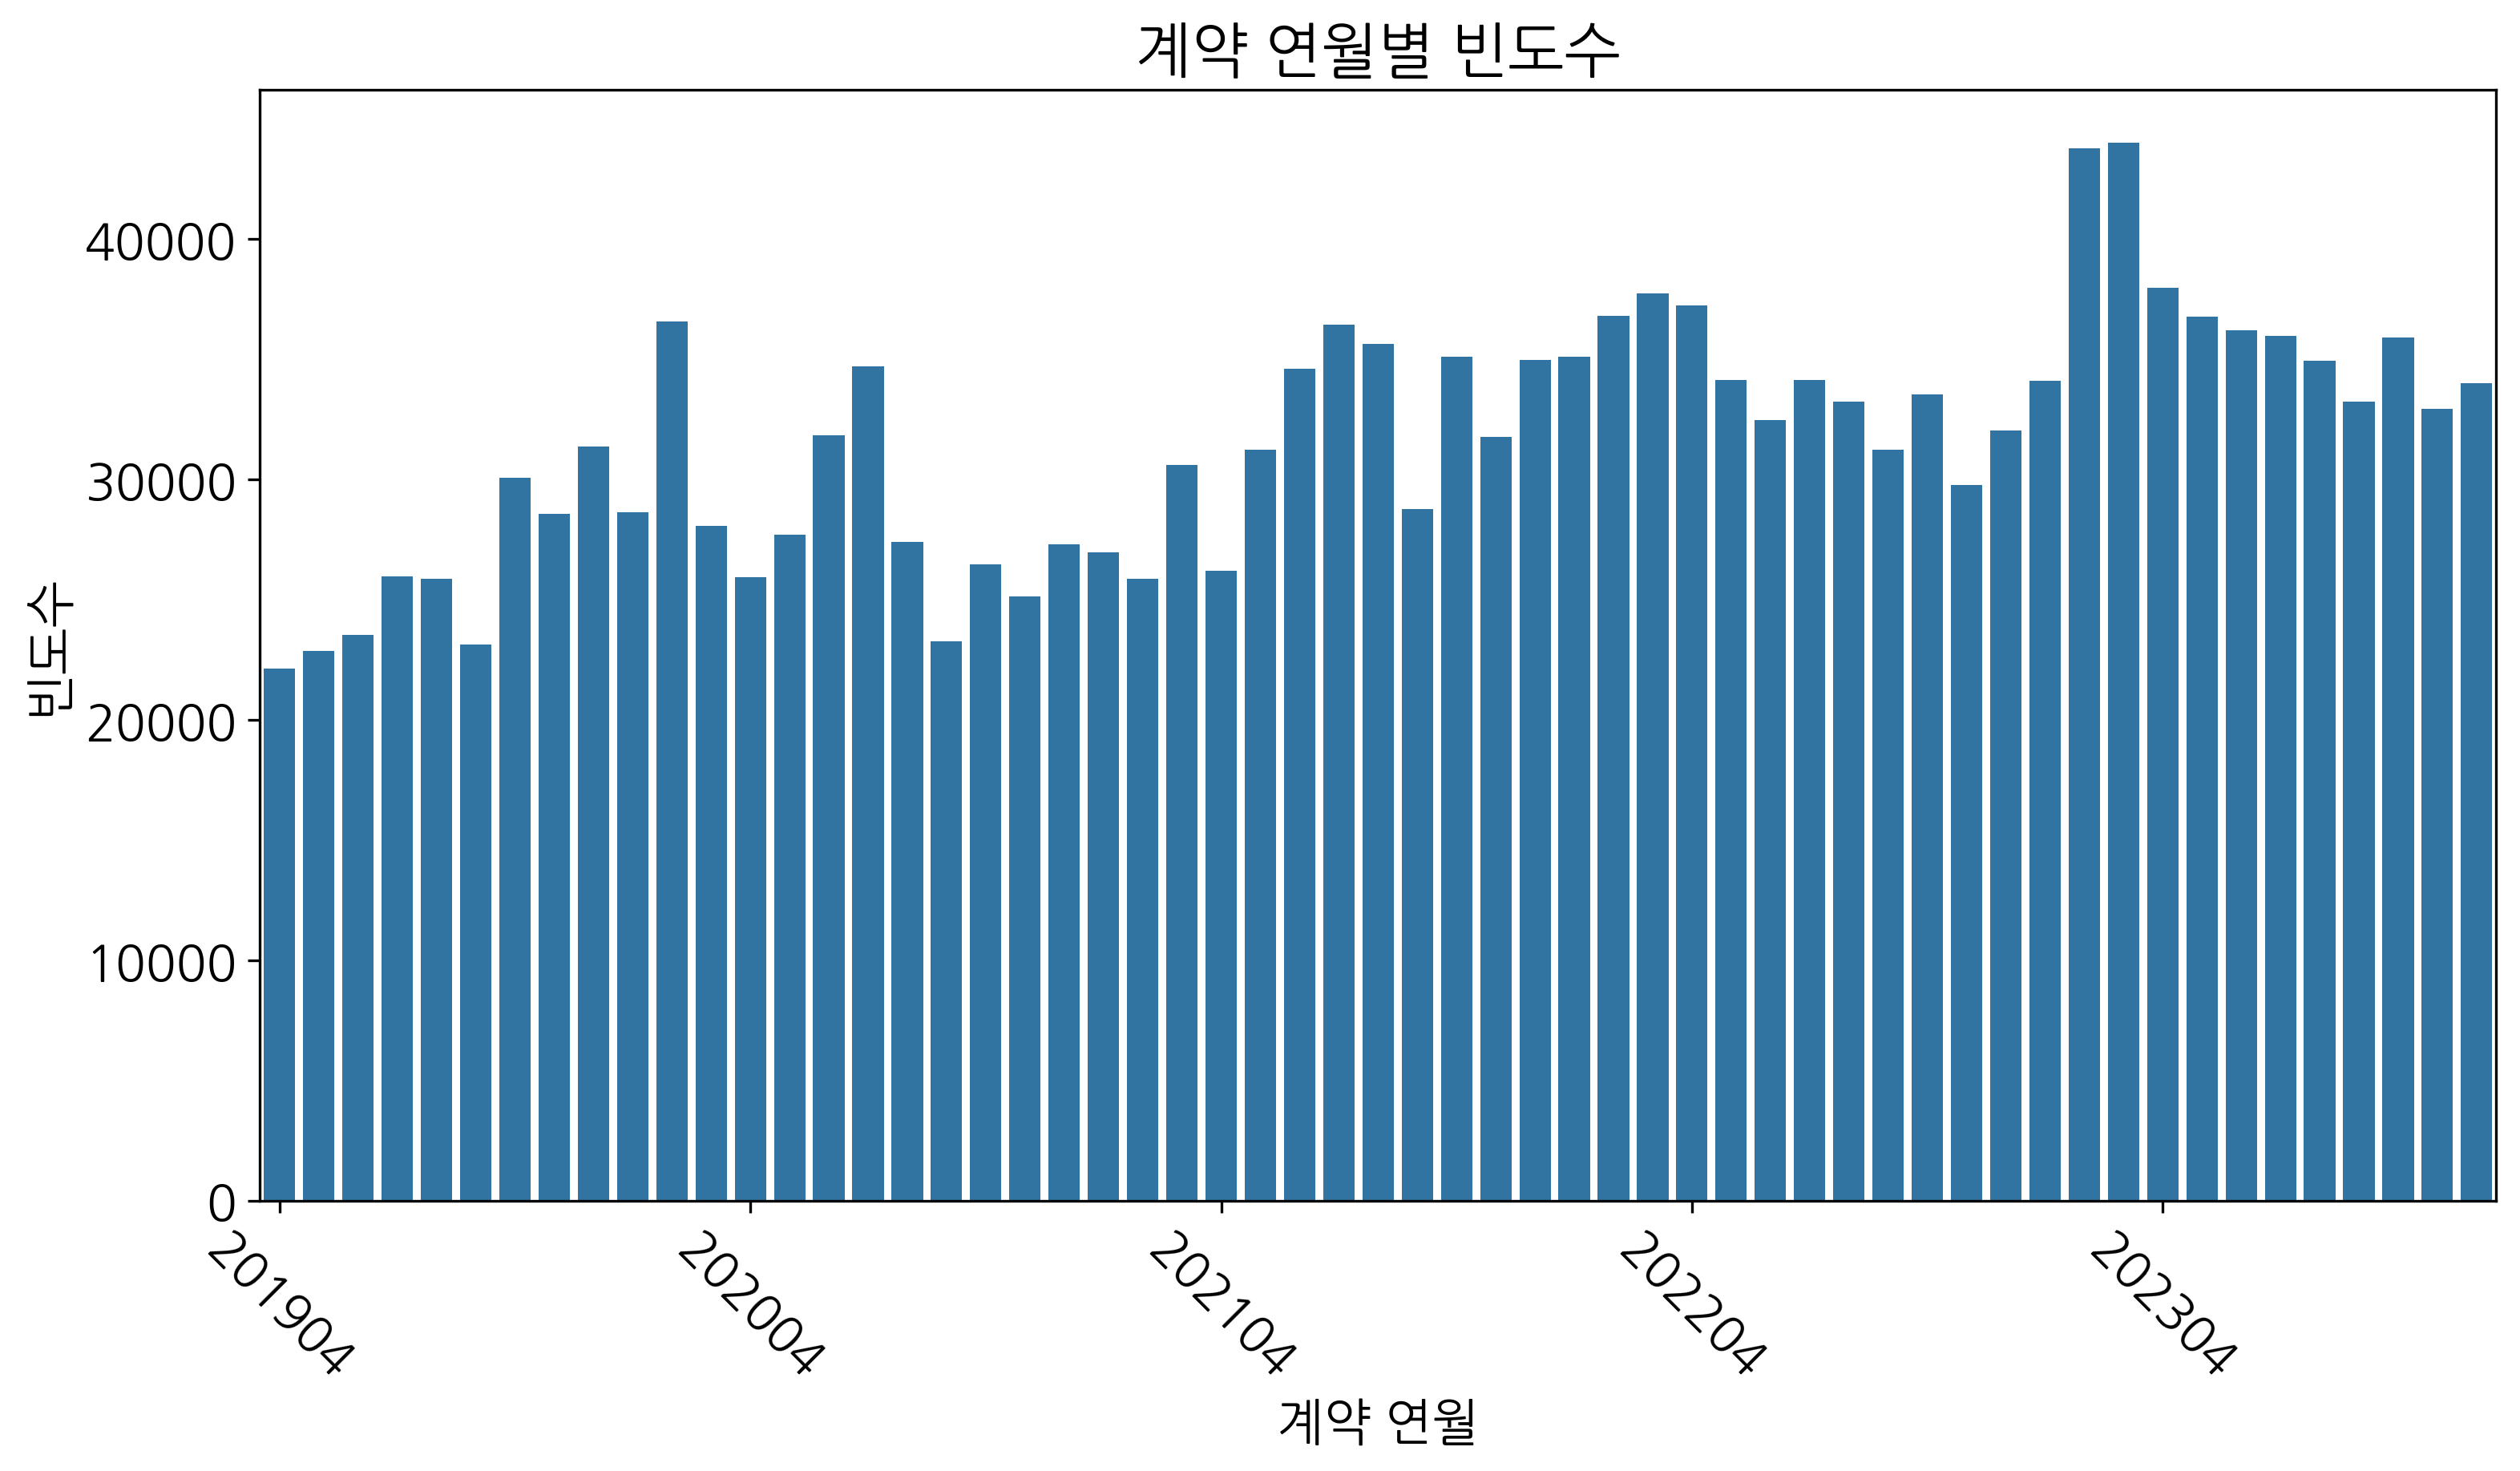

In [40]:
# 범주형 변수의 빈도 분석 및 시각화 함수
def plot_categorical_count(df, column, title, xlabel, order=None, figsize=(8, 6), rotation=0, step=None):
    plt.figure(figsize=figsize, dpi=300)
    sns.countplot(x=column, data=df, order=order)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('빈도수')
    
    # x축 tick 간격 설정
    if step:
        plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(step))
    
    plt.xticks(rotation=rotation)
    plt.show()

# 계약 유형 (contract_type)
plot_categorical_count(train_df, 'contract_type', '계약 유형별 빈도수', '계약 유형 (0: 신규, 1: 갱신, 2: 모름)', figsize=(8, 6))

# 계약 요일 (contract_weekday)
weekday_mapping = {0: '월요일', 1: '화요일', 2: '수요일', 3: '목요일', 4: '금요일', 5: '토요일', 6: '일요일'}
train_df['contract_weekday_kor'] = train_df['contract_weekday'].map(weekday_mapping)
plot_categorical_count(train_df, 'contract_weekday_kor', '계약 요일별 빈도수', '계약 요일', order=['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일'], figsize=(10, 6))

# 계약 연월 (contract_year_month)
plot_categorical_count(train_df, 'contract_year_month', '계약 연월별 빈도수', '계약 연월', figsize=(12, 6), rotation=315, step=12)

## (2) 이변량 분석

### 수치형 변수 간 관게

In [42]:
train_df.dtypes

index                                      int64
area_m2                                  float64
contract_year_month                        int64
contract_day                               int64
contract_type                              int64
floor                                      int64
built_year                                 int64
latitude                                 float64
longitude                                float64
age                                        int64
deposit                                  float64
_type                                     object
nearest_subway_distance_km               float64
interest_rate                            float64
prev_month_interest_rate                 float64
nearest_elementary_distance_km           float64
nearest_middle_distance_km               float64
nearest_high_distance_km                 float64
nearest_park_distance_km                 float64
nearest_park_area                        float64
complex_id          

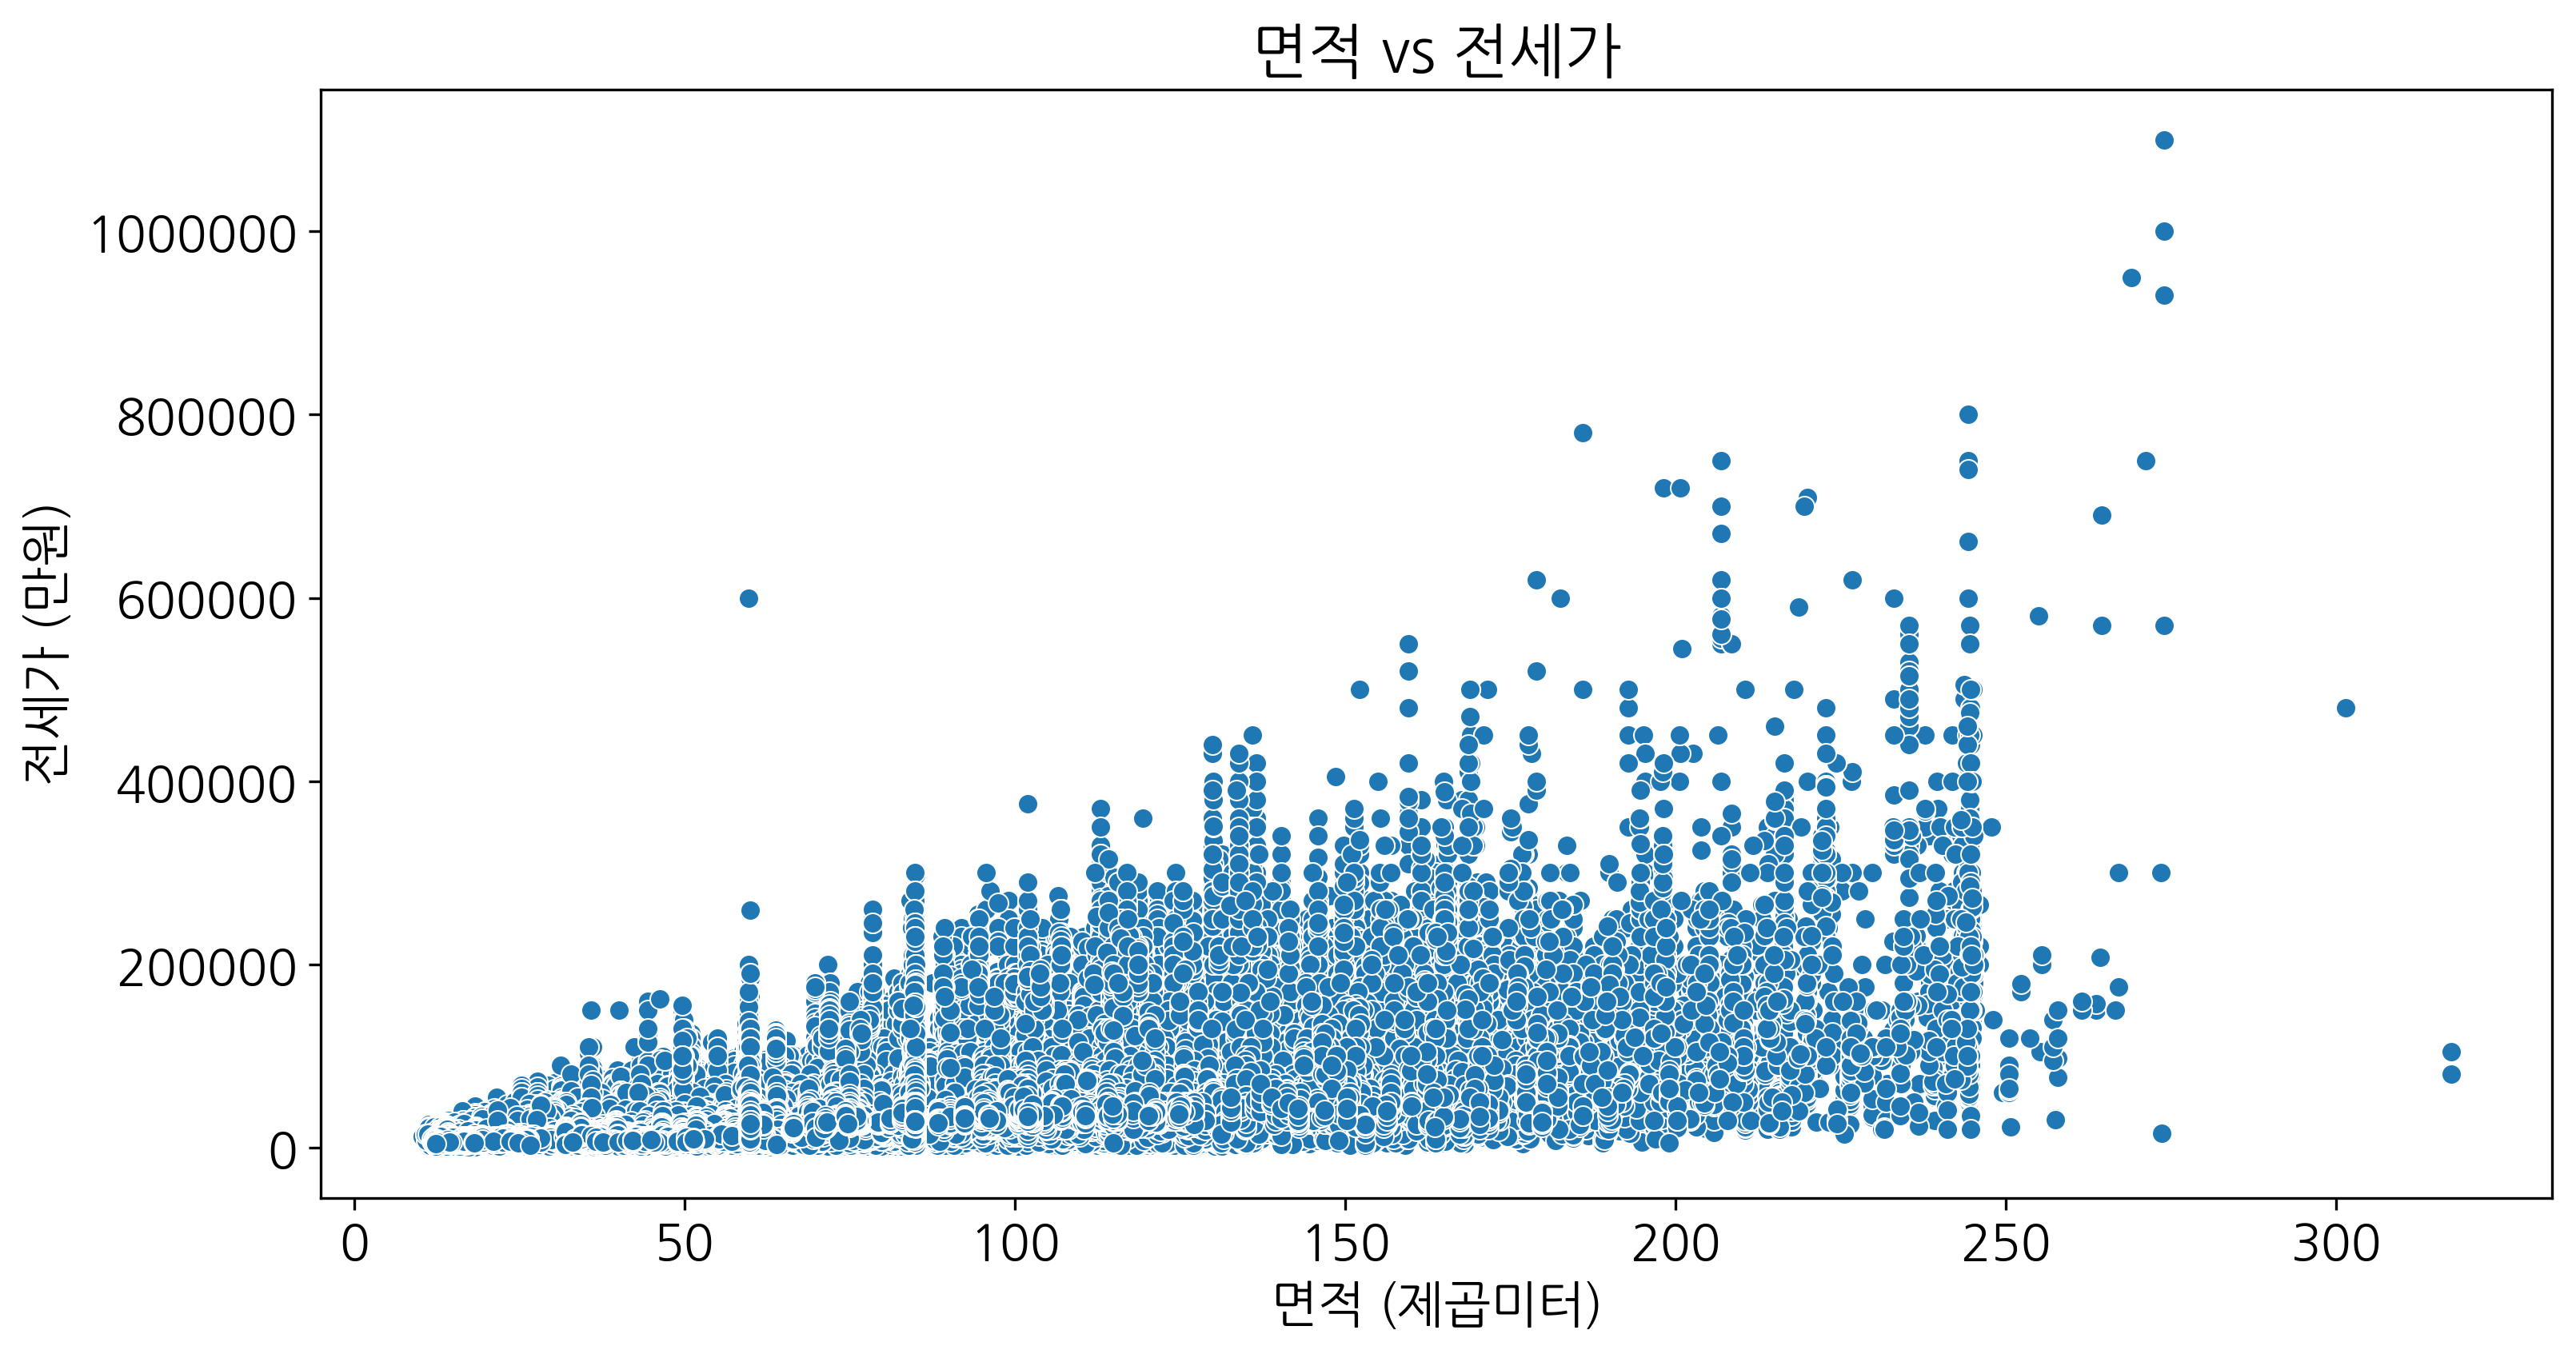

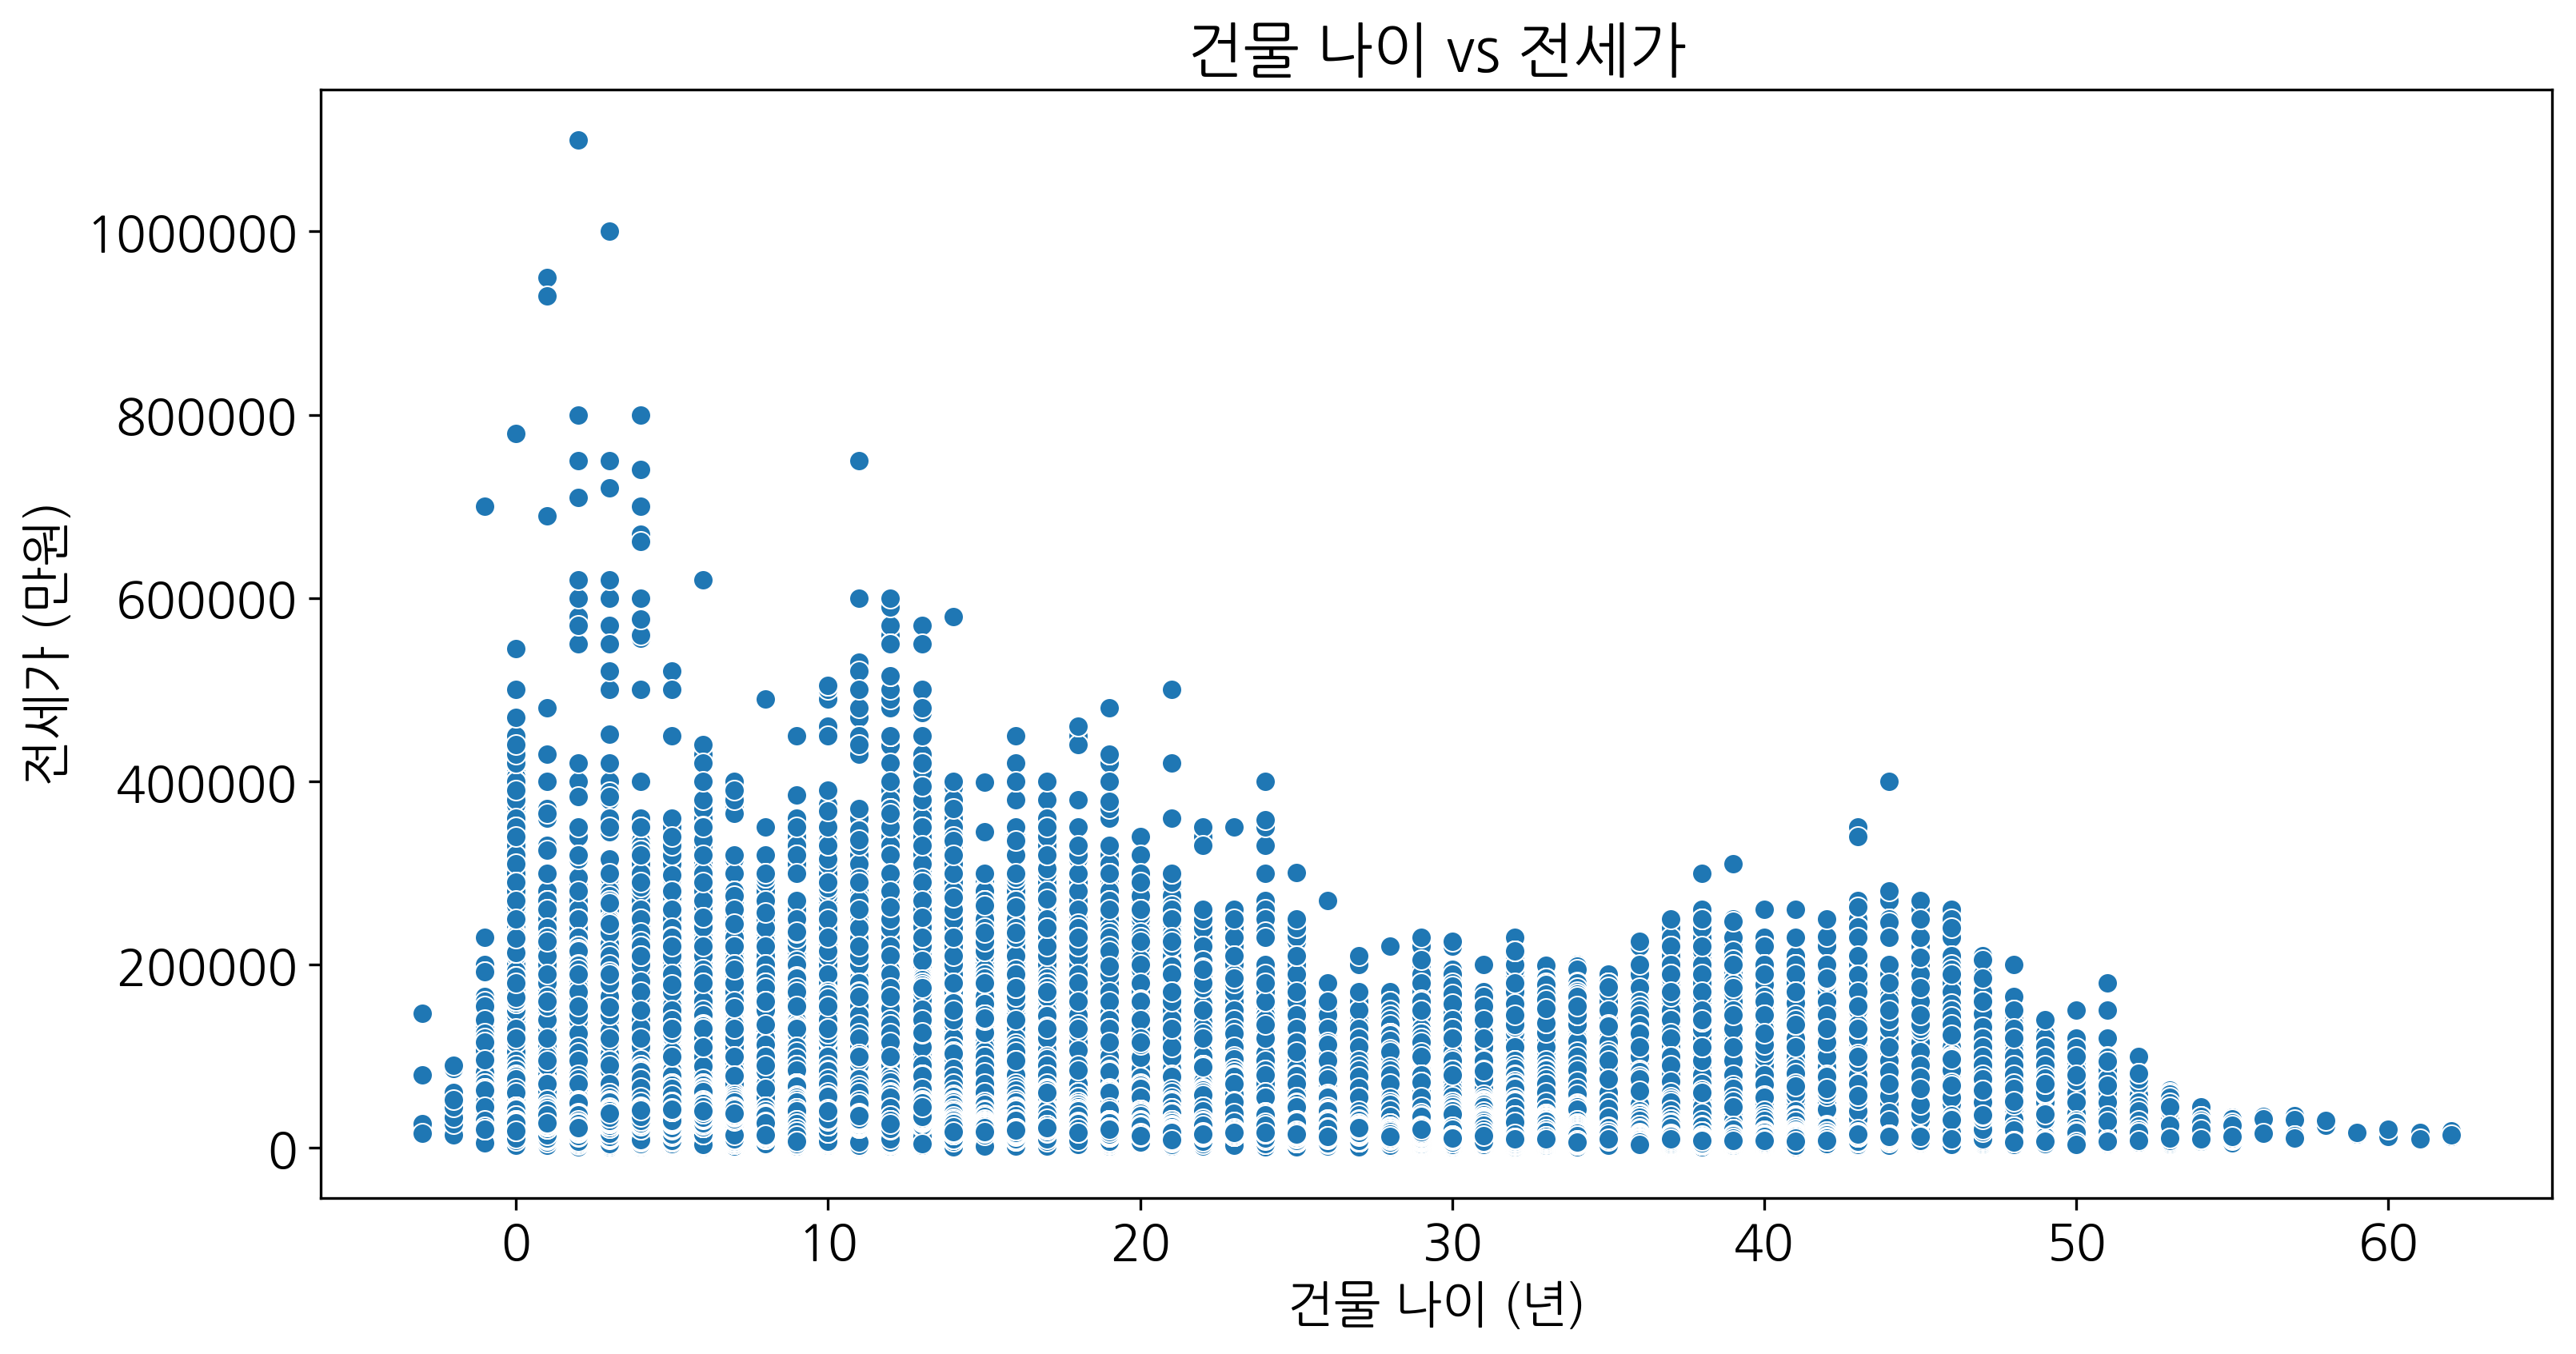

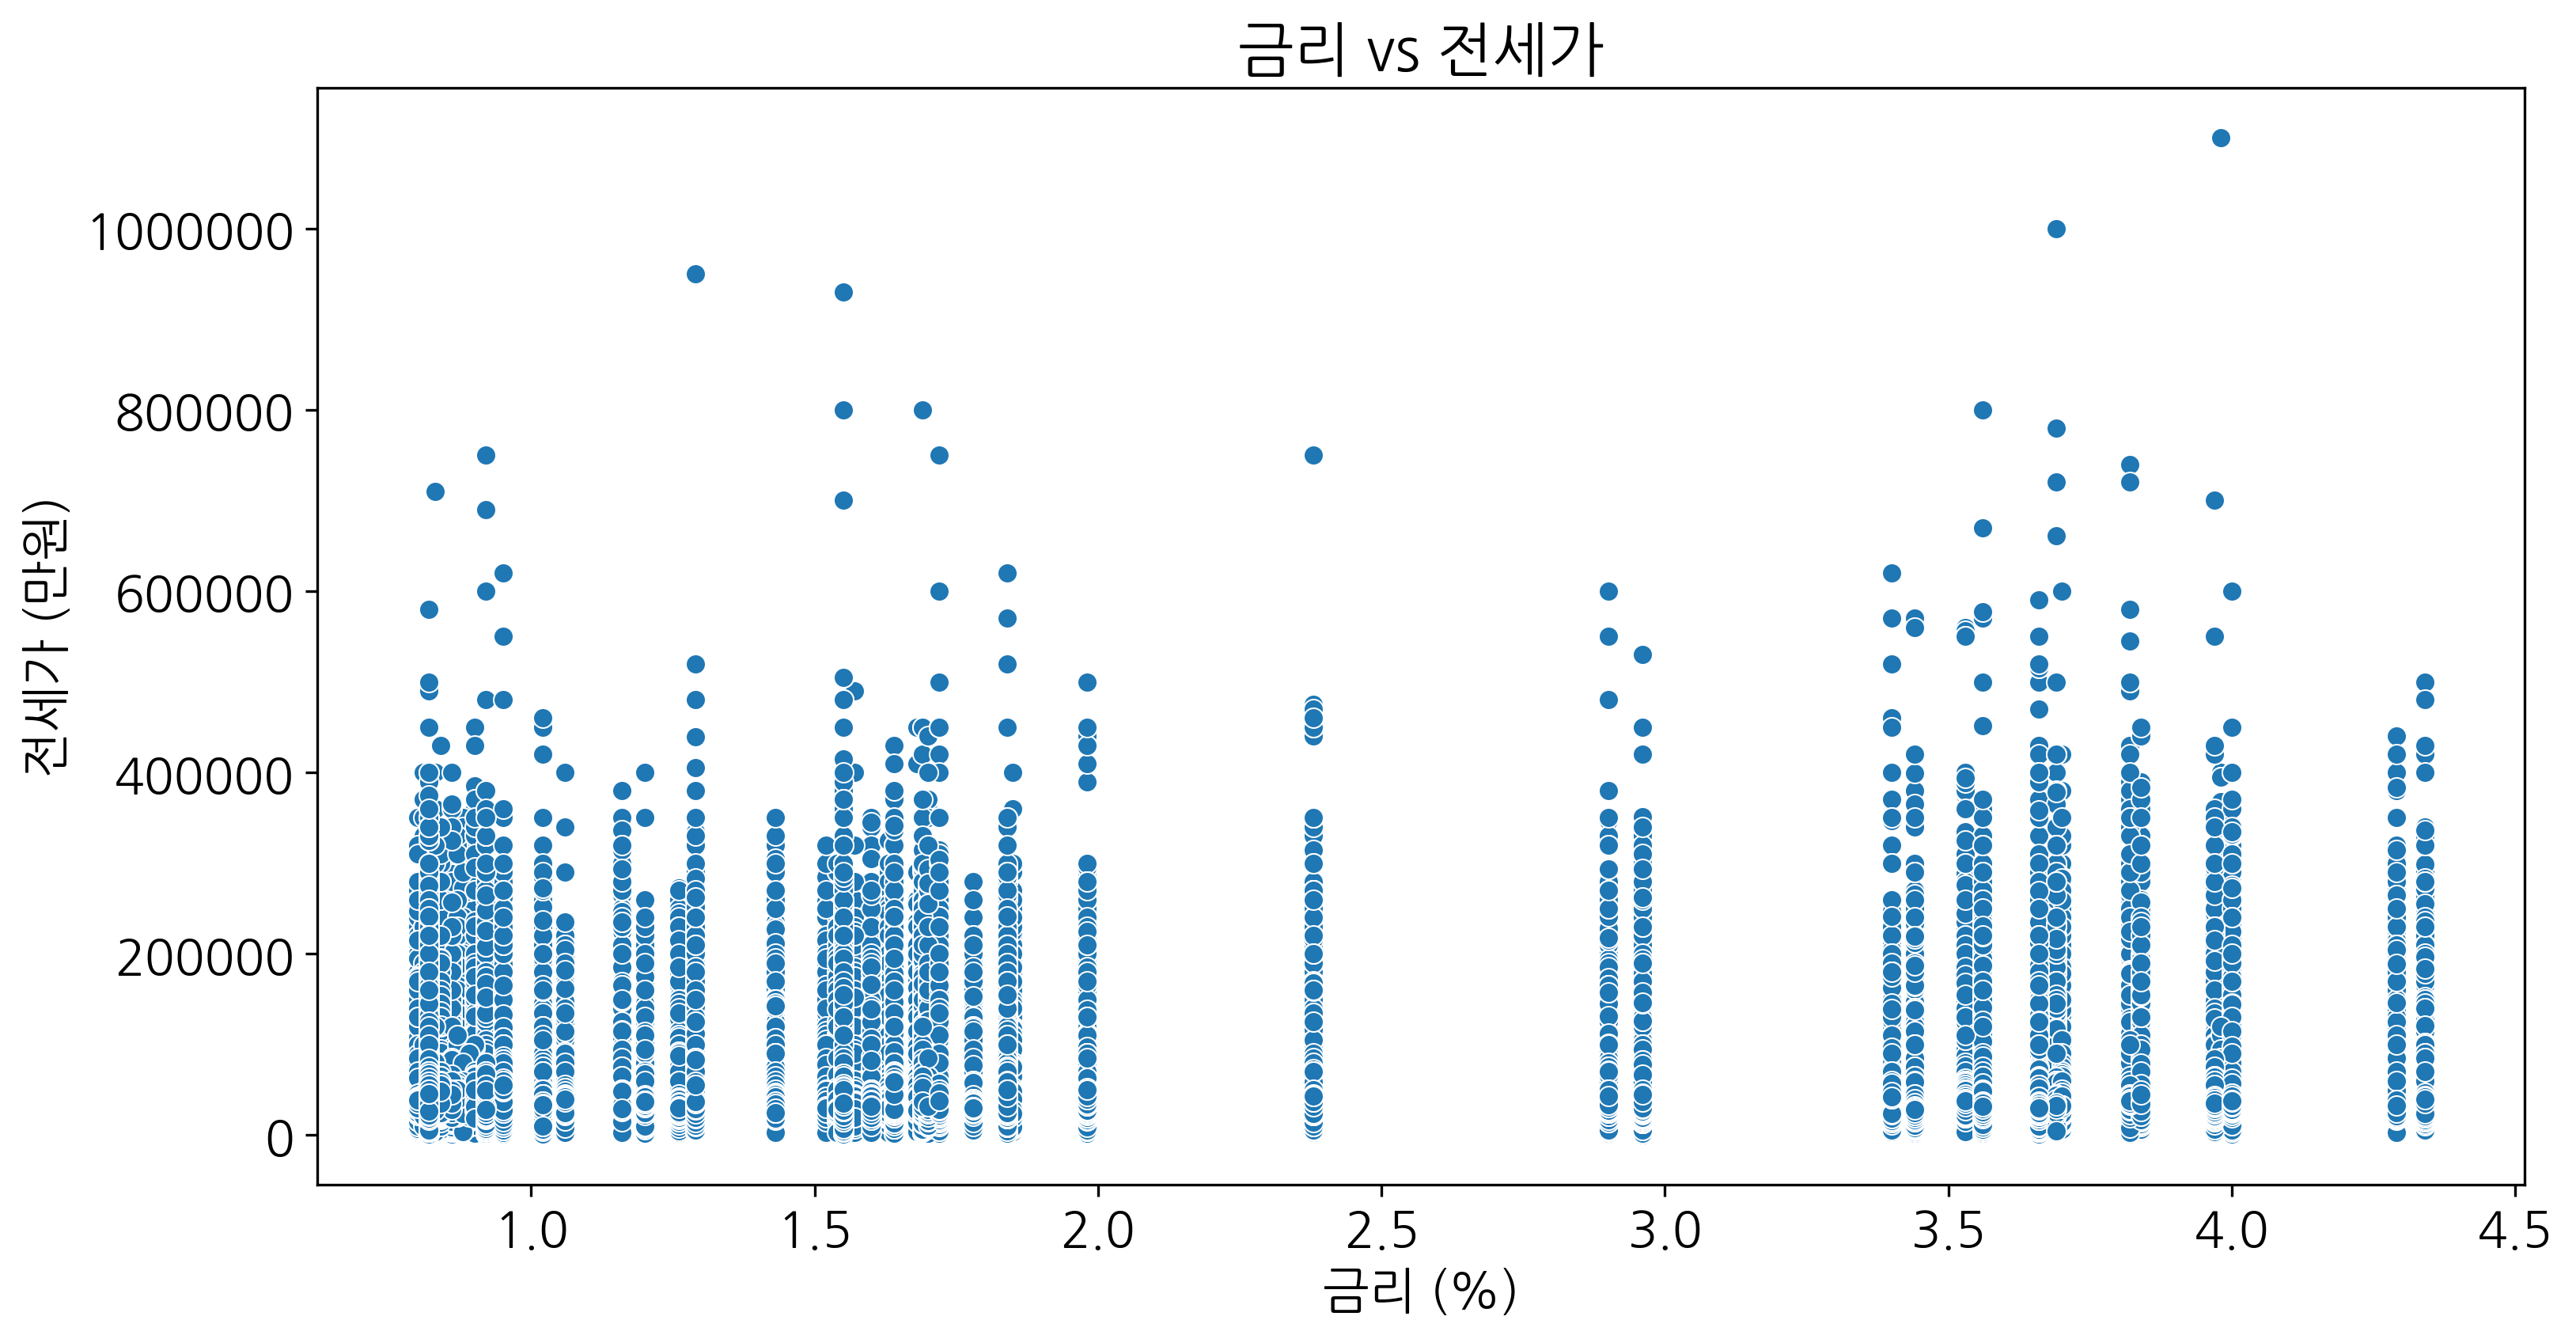

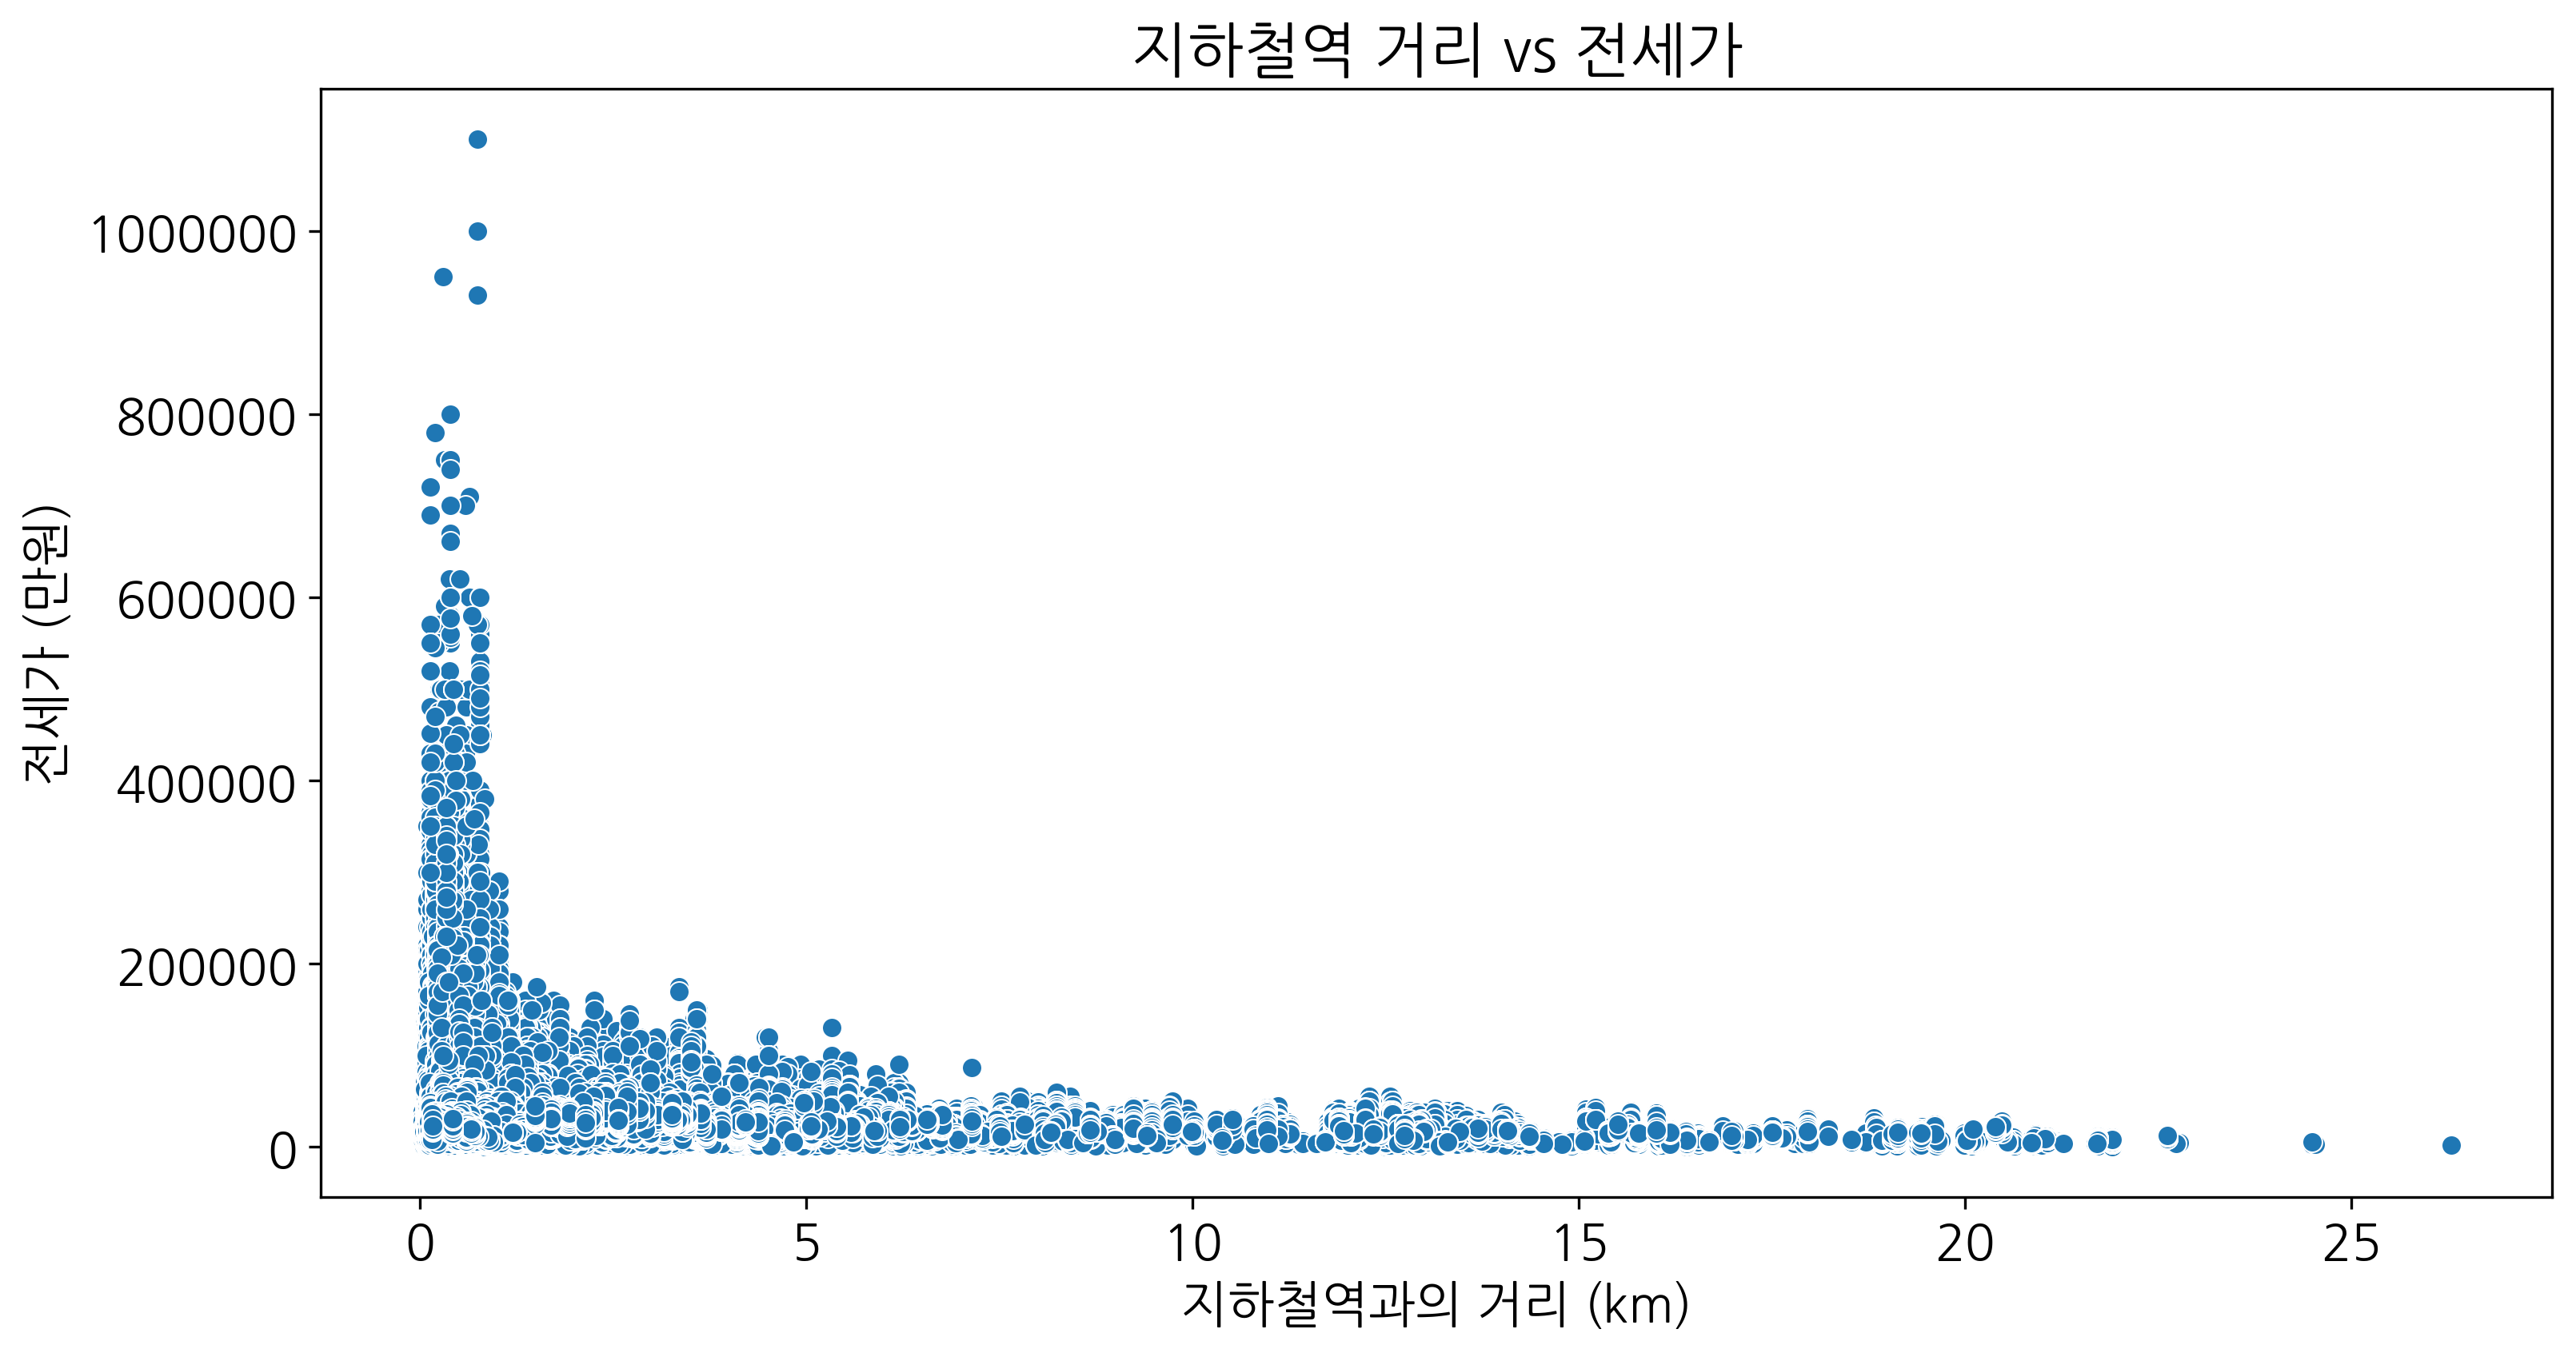

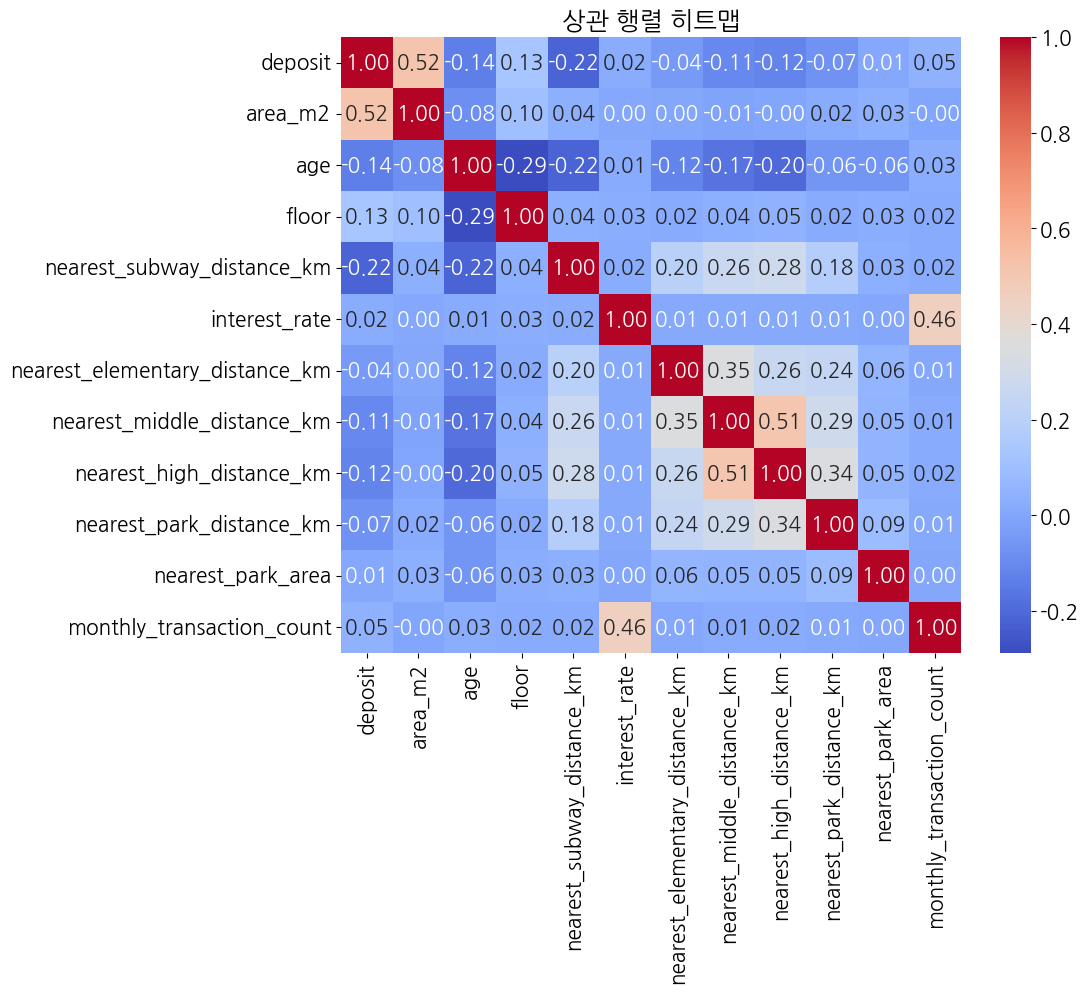

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# 산점도 및 회귀선 시각화 함수
def plot_scatter(df, x, y, title, xlabel, ylabel, figsize=(12, 6)):
    plt.figure(figsize=figsize, dpi=300)
    sns.scatterplot(x=x, y=y, data=df)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())
    plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter())
    plt.gca().ticklabel_format(useOffset=False, style='plain', axis='both')
    plt.show()

# 면적 vs 전세가
plot_scatter(train_df, 'area_m2', 'deposit', '면적 vs 전세가', '면적 (제곱미터)', '전세가 (만원)')

# 건물 나이 vs 전세가
plot_scatter(train_df, 'age', 'deposit', '건물 나이 vs 전세가', '건물 나이 (년)', '전세가 (만원)')

# 금리 vs 전세가
plot_scatter(train_df, 'interest_rate', 'deposit', '금리 vs 전세가', '금리 (%)', '전세가 (만원)')

# 지하철역 거리 vs 전세가
plot_scatter(train_df, 'nearest_subway_distance_km', 'deposit', '지하철역 거리 vs 전세가', '지하철역과의 거리 (km)', '전세가 (만원)')


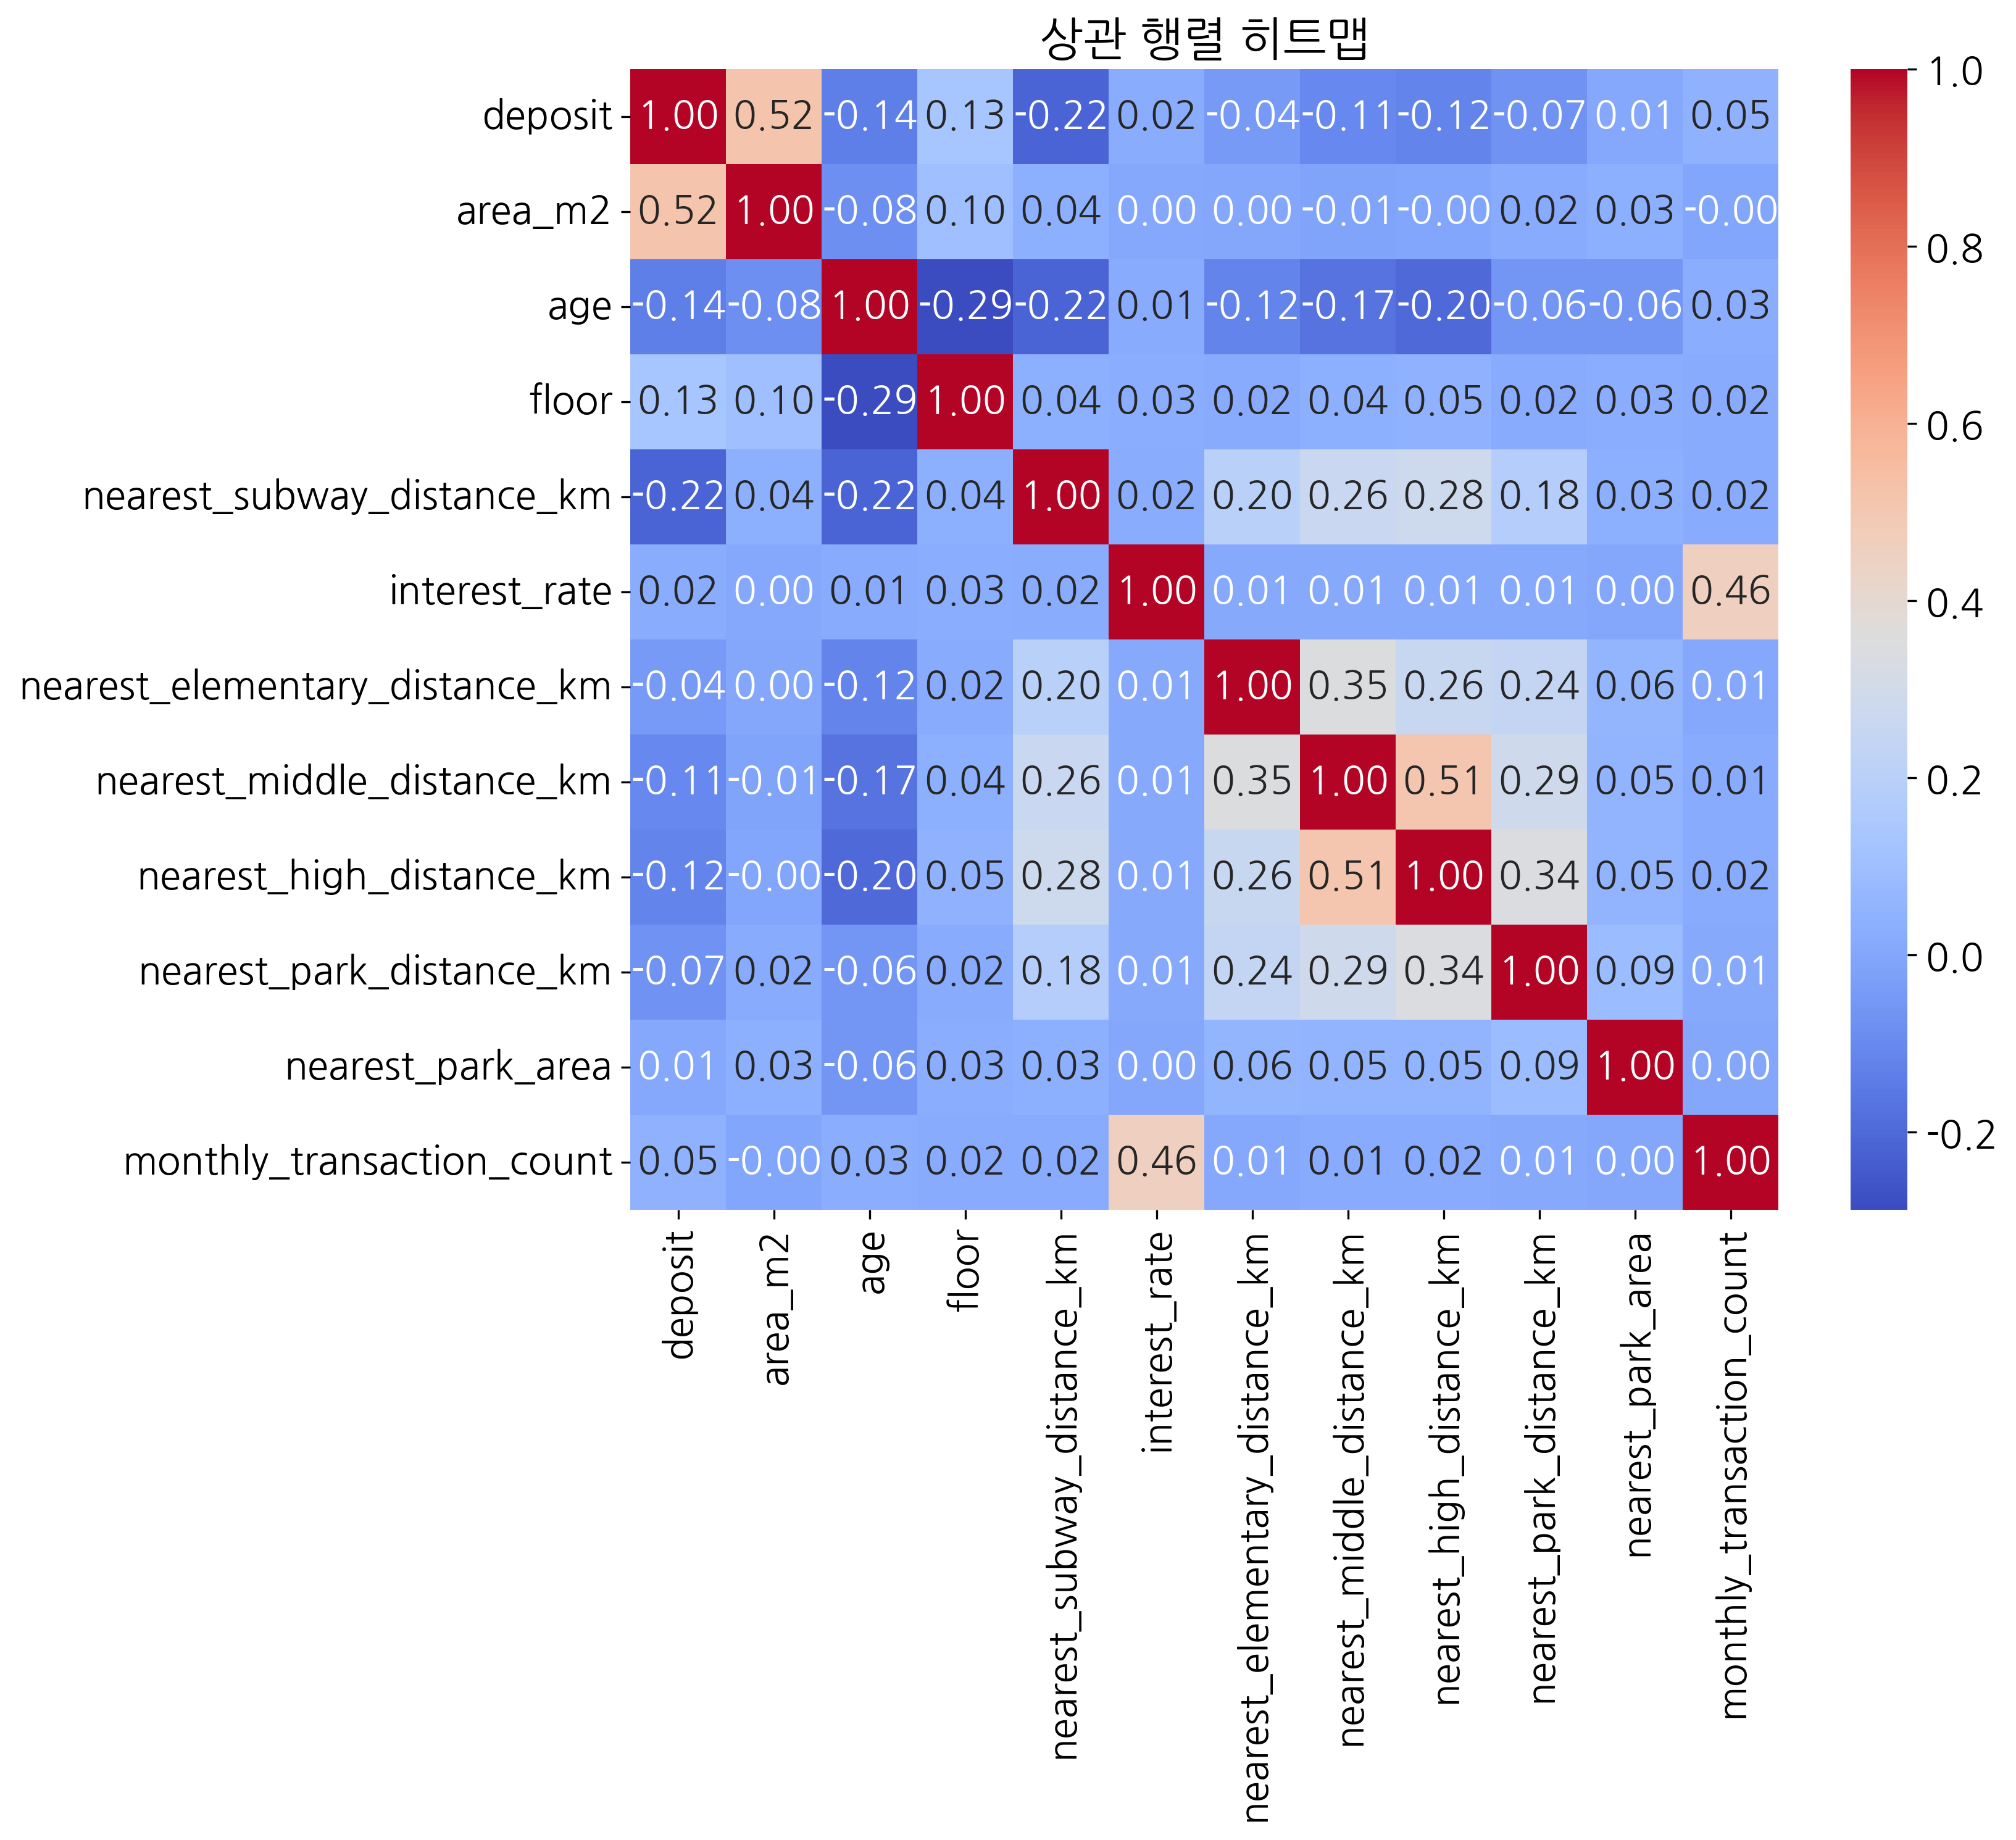

In [44]:
# 상관계수 계산 및 히트맵 시각화 함수
def plot_corr_heatmap(train_df, cols, title, figsize=(10, 8)):
    corr_matrix = train_df[cols].corr()
    plt.figure(figsize=figsize, dpi=300)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(title)
    plt.show()

# 상관계수 히트맵
corr_cols = ['deposit', 'area_m2', 'age', 'floor', 'nearest_subway_distance_km', 'interest_rate', 'nearest_elementary_distance_km', 'nearest_middle_distance_km',
 'nearest_high_distance_km', 'nearest_park_distance_km', 'nearest_park_area', 'monthly_transaction_count']
plot_corr_heatmap(train_df, corr_cols, '상관 행렬 히트맵')

### 수치형 변수와 범주형 변수 간 관계


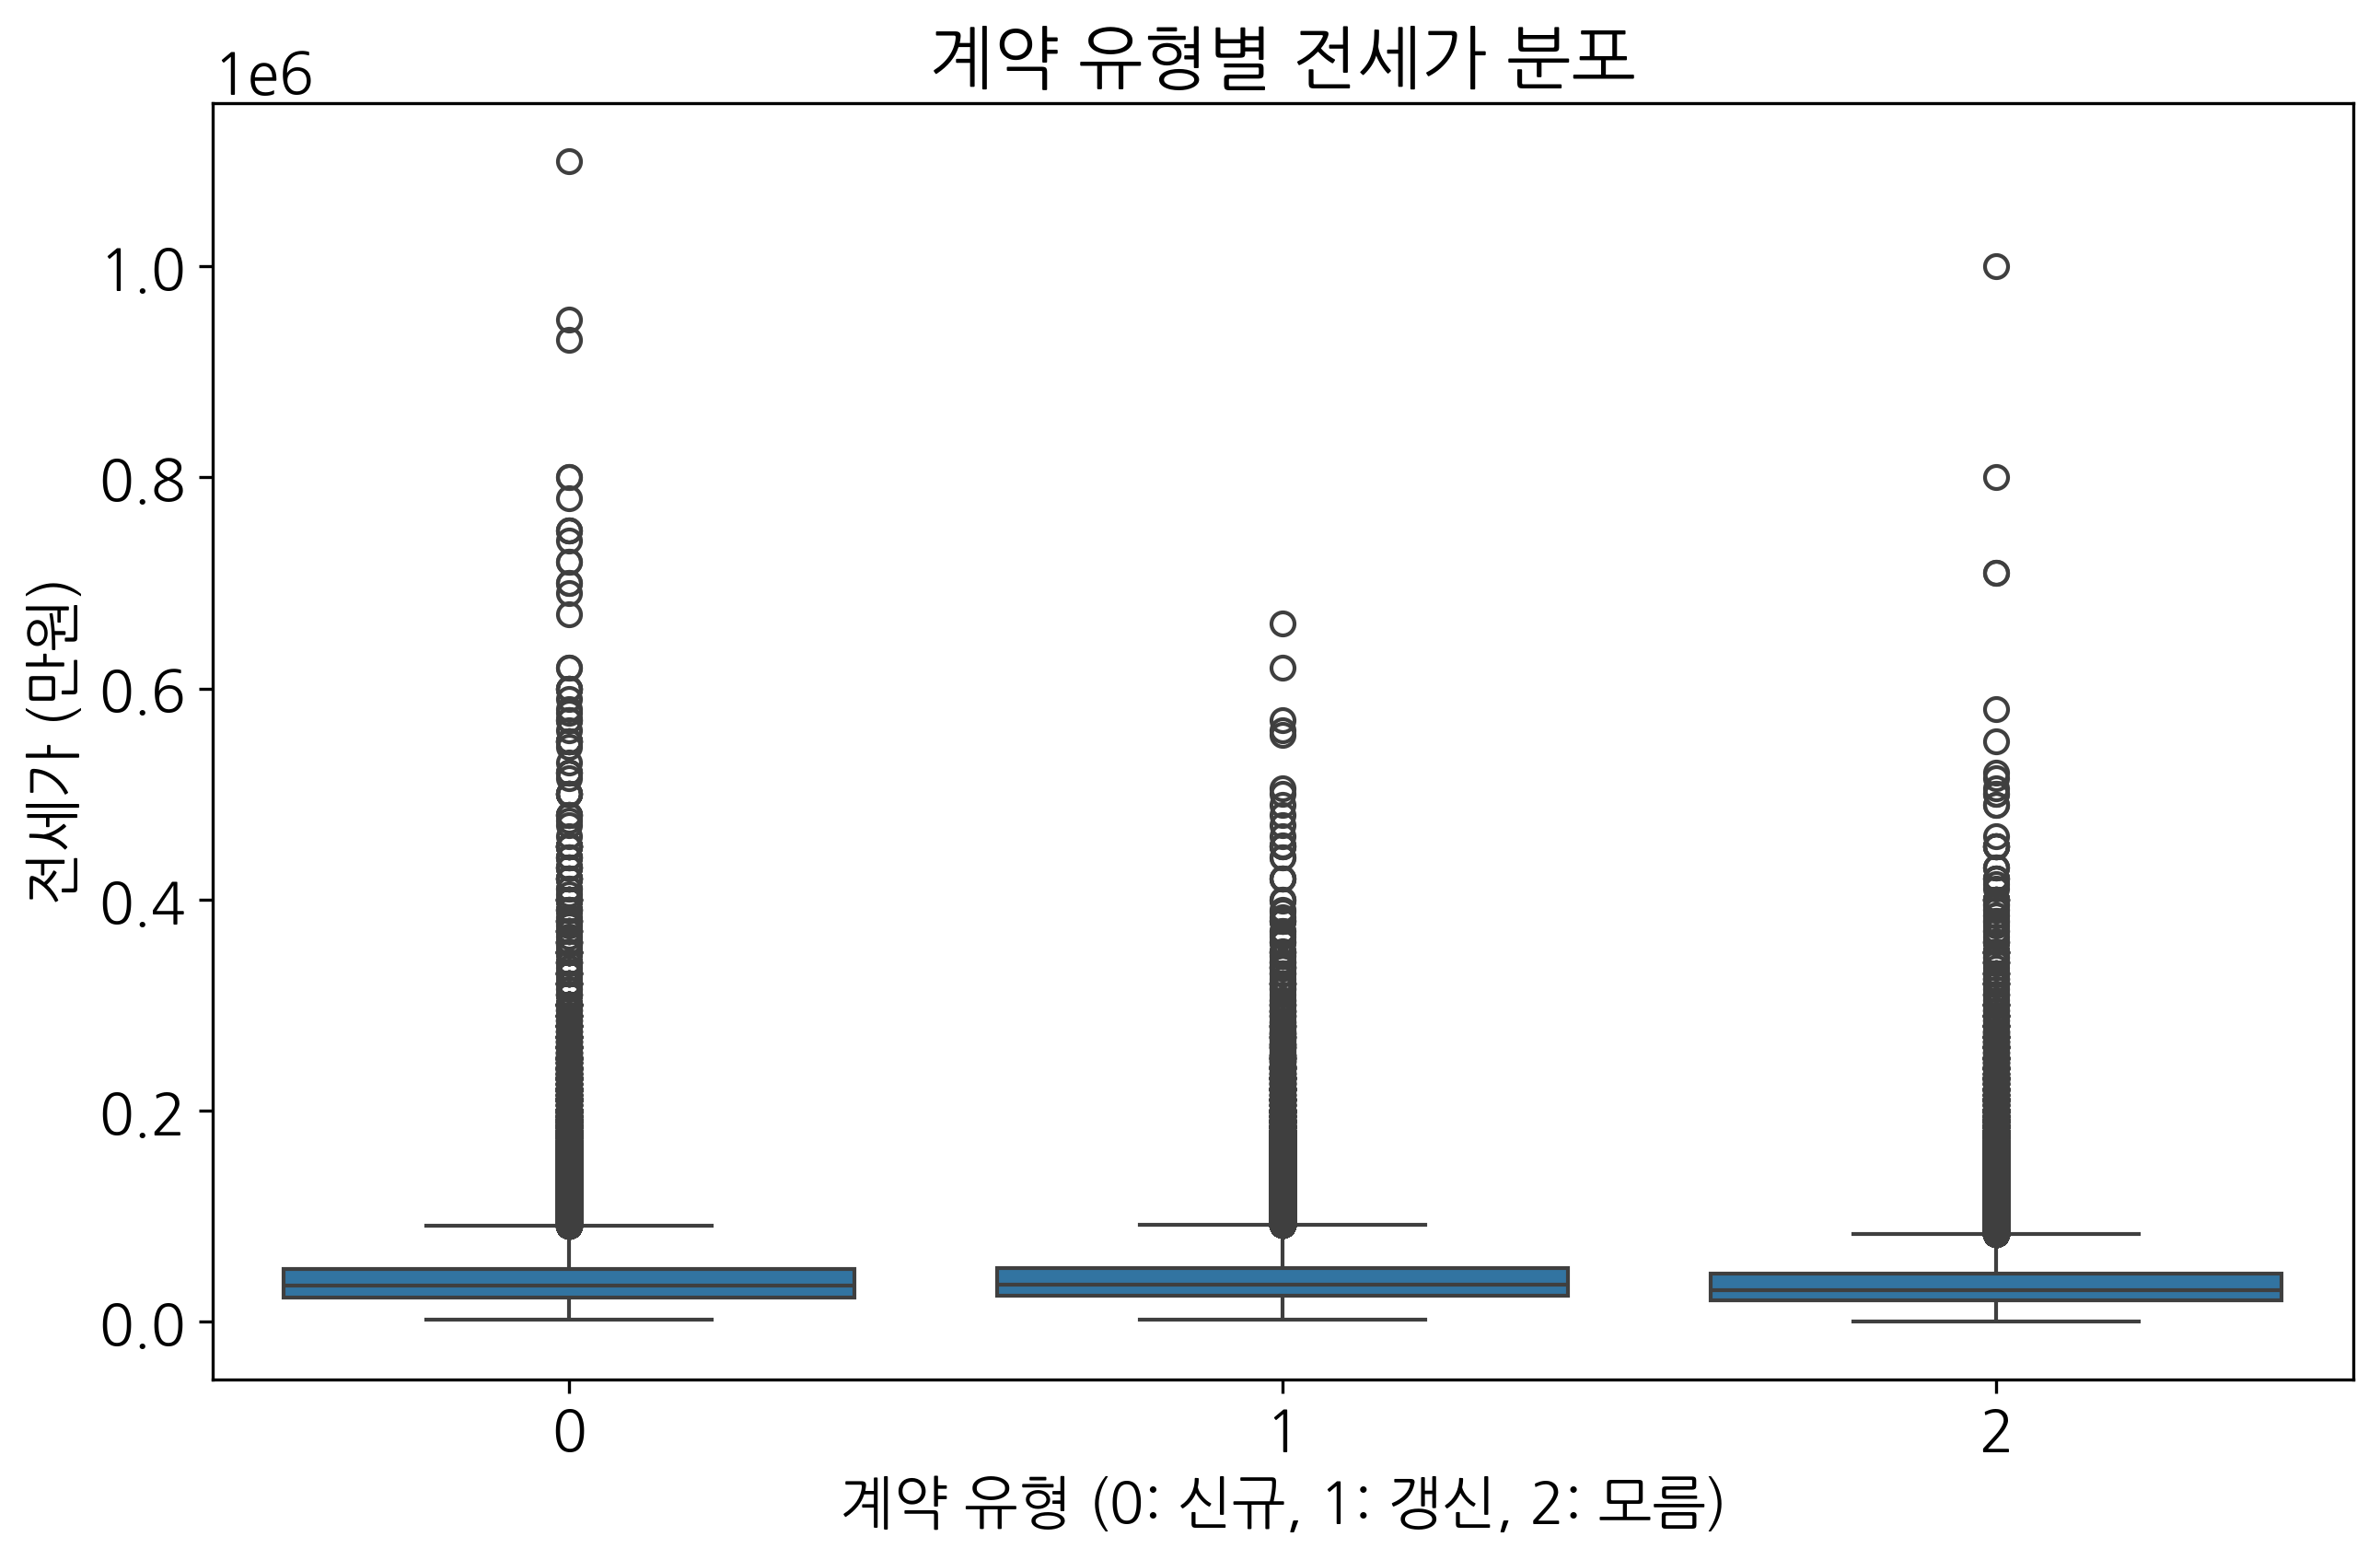

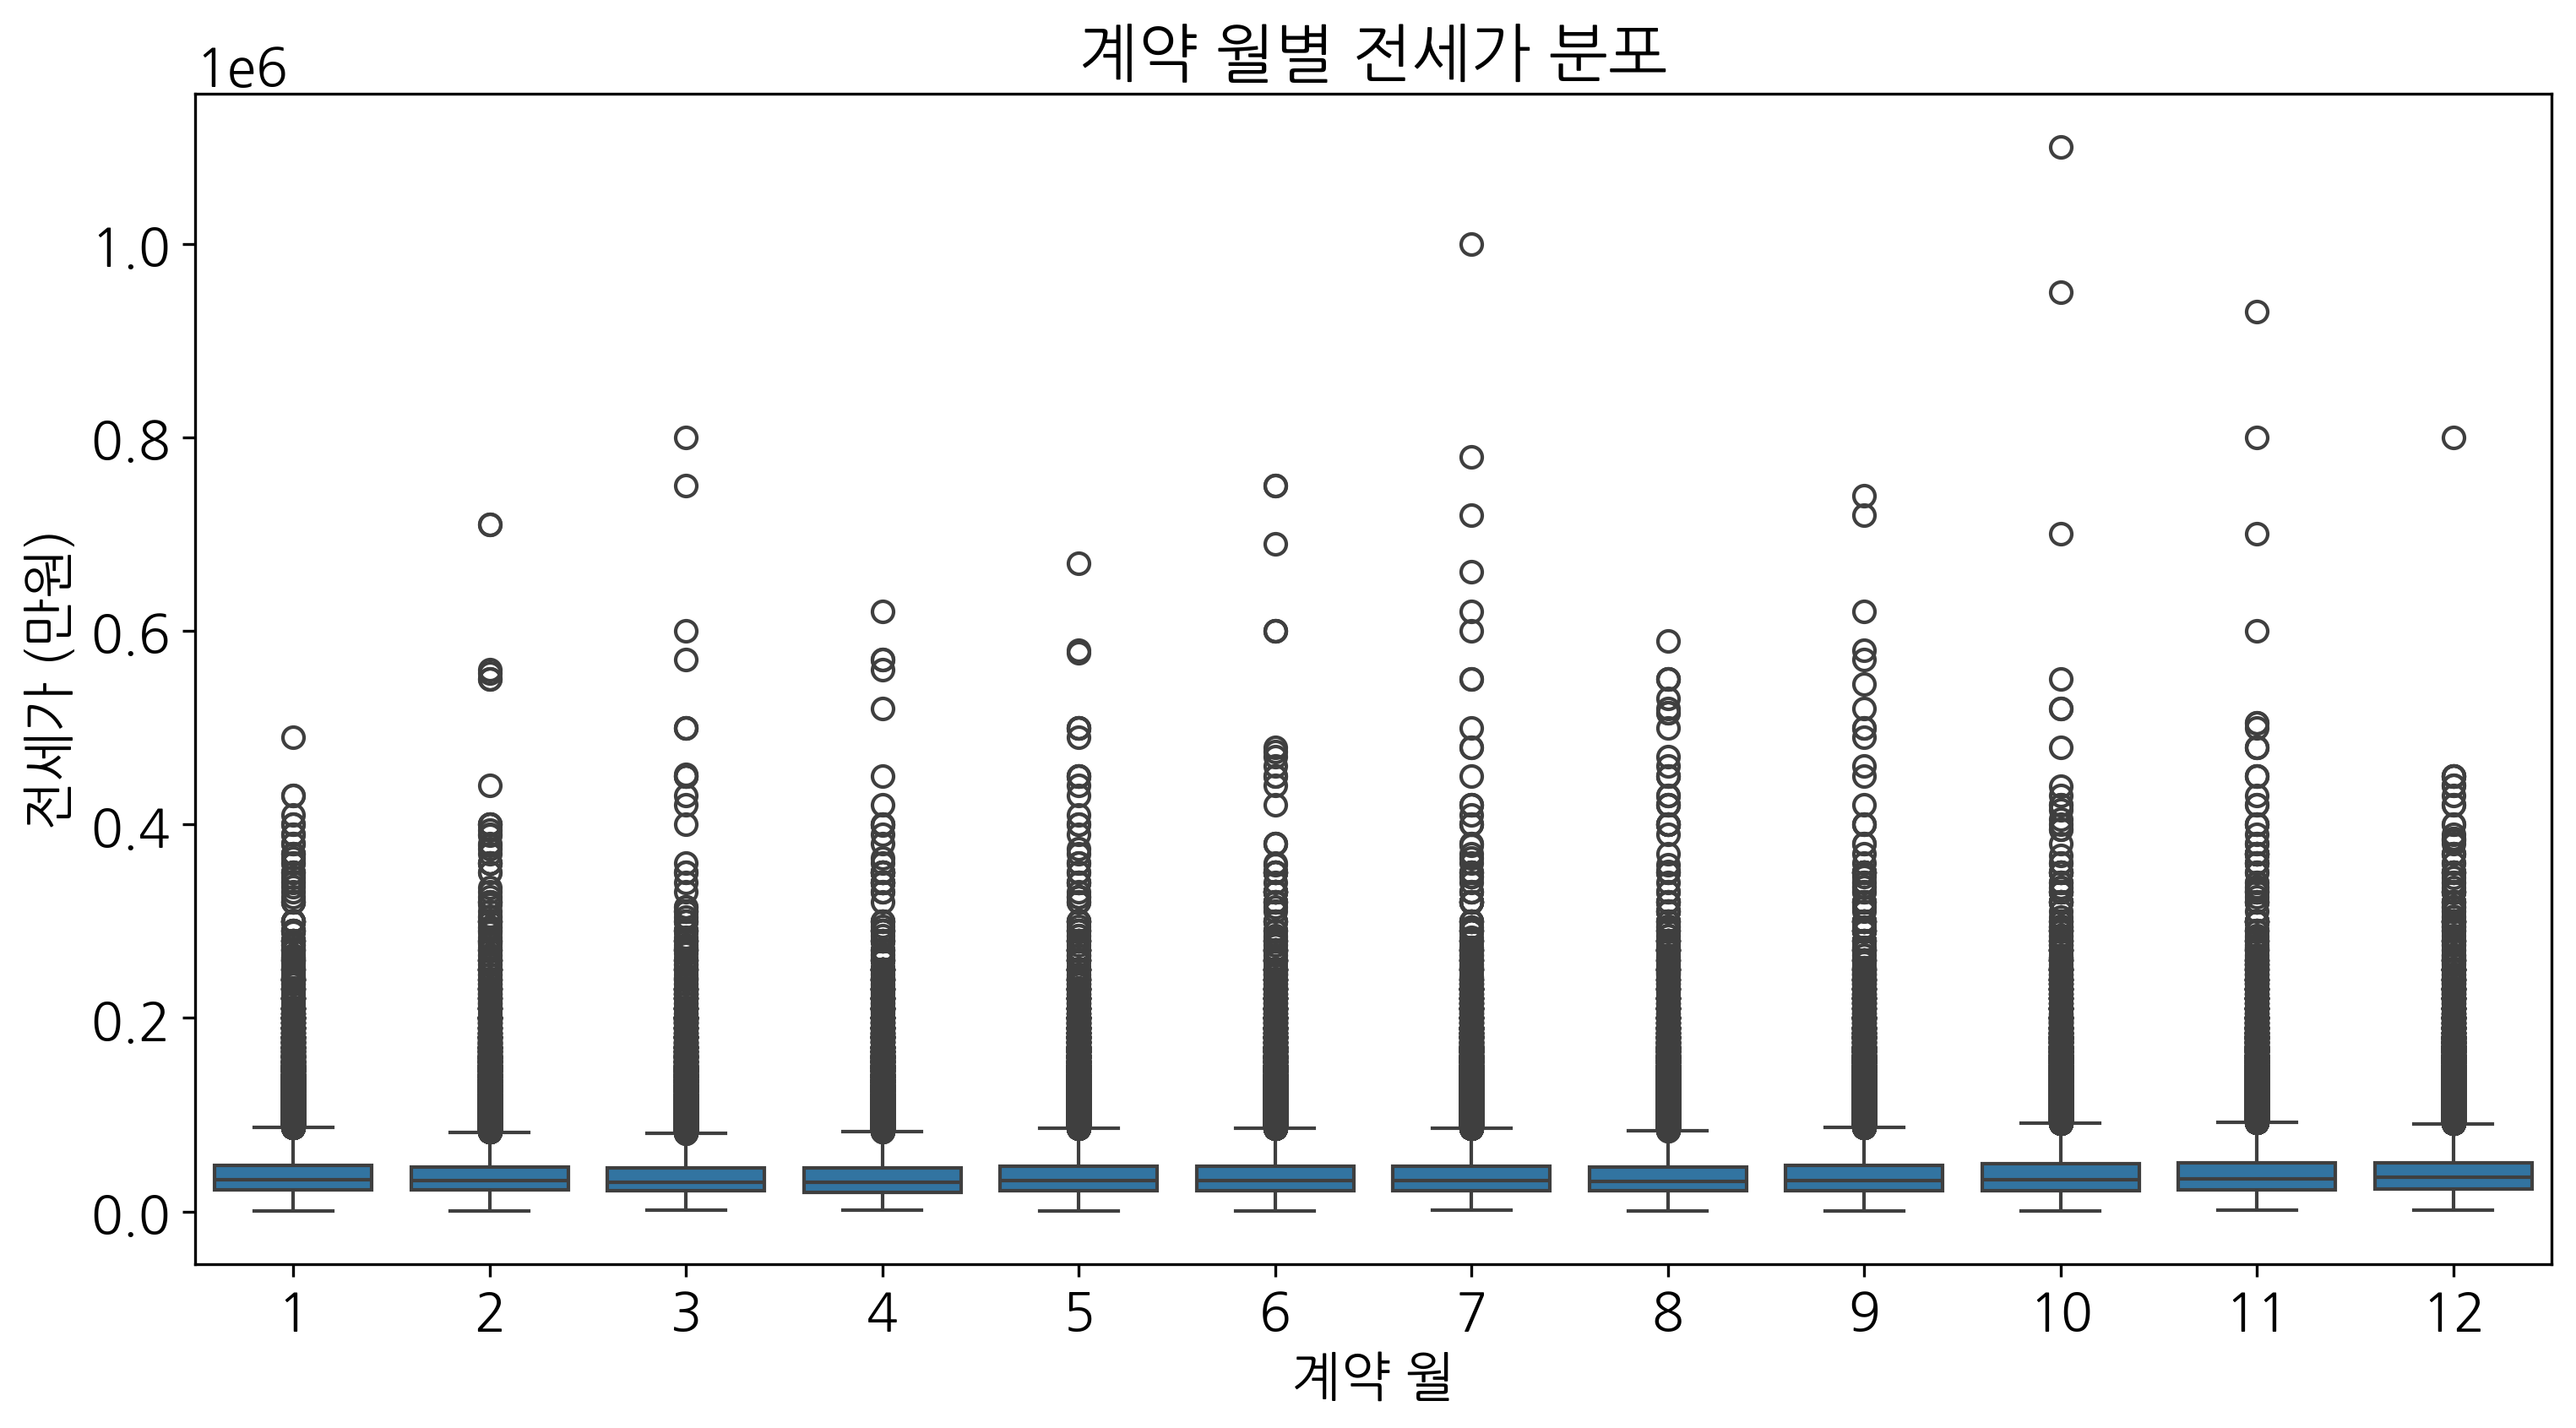

In [46]:
# 박스플롯 시각화 함수
def plot_boxplot(df, x, y, title, xlabel, ylabel, figsize=(10, 6)):
    plt.figure(figsize=figsize, dpi=300)
    sns.boxplot(x=x, y=y, data=df)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# 계약 유형별 전세가 분포
plot_boxplot(train_df, 'contract_type', 'deposit', '계약 유형별 전세가 분포', '계약 유형 (0: 신규, 1: 갱신, 2: 모름)', '전세가 (만원)', figsize=(10, 6))

# 계약 월별 전세가 분포
plot_boxplot(train_df, 'contract_month', 'deposit', '계약 월별 전세가 분포', '계약 월', '전세가 (만원)', figsize=(12, 6))


In [51]:
print(
    train_df.groupby('contract_type').agg({
    'deposit': 'median'
}).rename(columns={
    'deposit': 'contract_type_deposit_median'
})
)
print(
    train_df.groupby('contract_month').agg({
    'deposit': 'median'
}).rename(columns={
    'deposit': 'contract_month_deposit_median'
})
)

               contract_type_deposit_median
contract_type                              
0                                 34000.000
1                                 35000.000
2                                 30000.000
                contract_month_deposit_median
contract_month                               
1                                   33000.000
2                                   31500.000
3                                   30500.000
4                                   30000.000
5                                   31500.000
6                                   32000.000
7                                   32000.000
8                                   31000.000
9                                   32000.000
10                                  33000.000
11                                  34000.000
12                                  35000.000


In [53]:
# ANOVA 검정 함수
def perform_anova(df, group_col, target_col):
    groups = [df[df[group_col] == val][target_col] for val in df[group_col].unique()]
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"ANOVA 검정 결과: F-statistic={f_stat:.2f}, p-value={p_value:.4f}")

# 계약 유형별 전세가 차이 검정 (ANOVA)
perform_anova(train_df, 'contract_type', 'deposit')

ANOVA 검정 결과: F-statistic=8998.13, p-value=0.0000


## (3) 시계열 분석

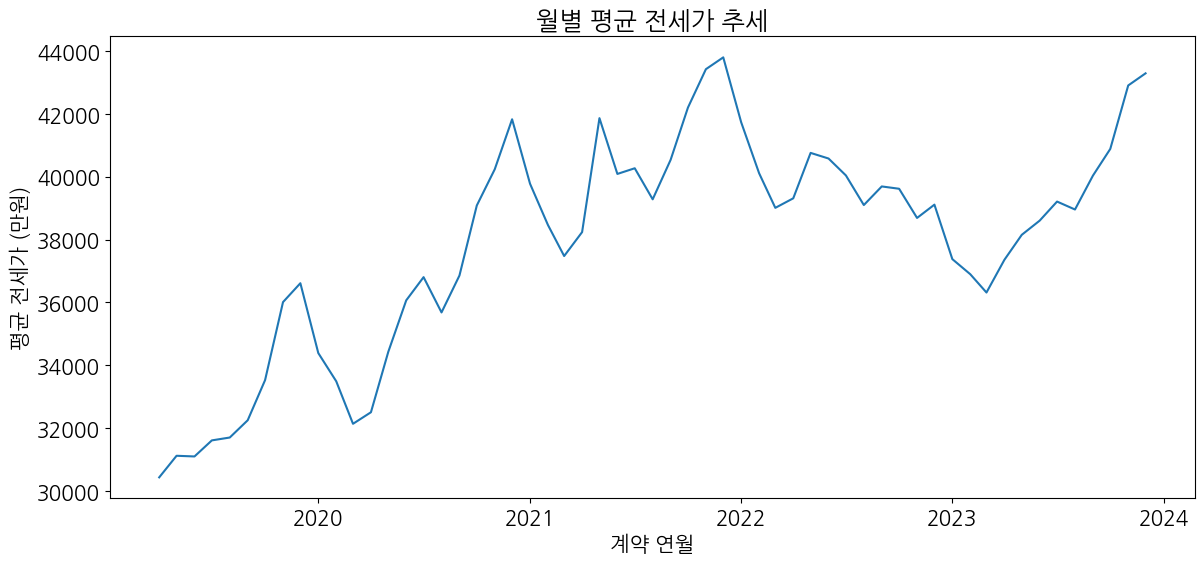

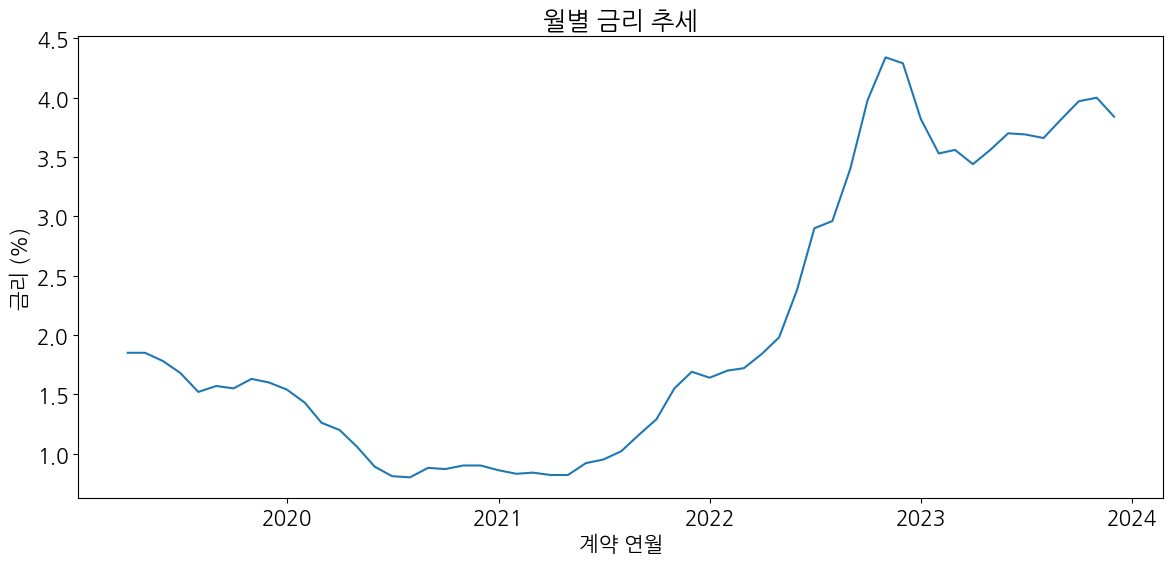

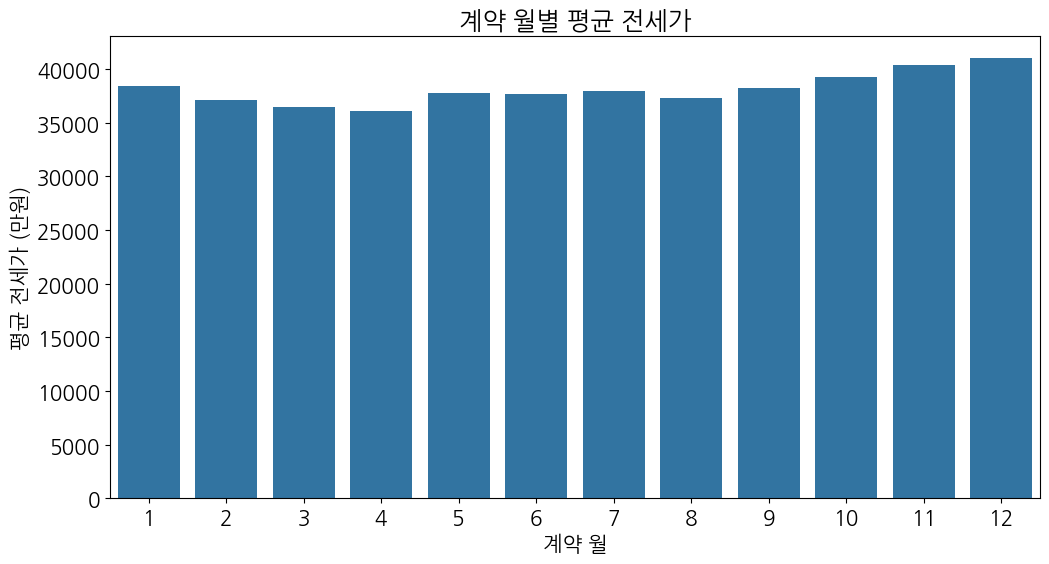

In [73]:
# 시계열 분석 시각화 함수
def plot_time_series(df, x, y, title, xlabel, ylabel, figsize=(14, 6)):
    plt.figure(figsize=figsize)
    sns.lineplot(x=x, y=y, data=df)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# 월별 평균 전세가 추세
def plot_monthly_avg_deposit(df):
    # 월별 평균 전세가 계산
    monthly_avg_deposit = df.groupby('contract_year_month')['deposit'].mean().reset_index()

    # 계약 연월을 날짜 형식으로 변환하여 시각화 (변형된 데이터를 df에 적용하지 않음)
    monthly_avg_deposit['contract_year_month'] = pd.to_datetime(monthly_avg_deposit['contract_year_month'].astype(str), format='%Y%m')

    # 라인 차트 시각화
    plot_time_series(monthly_avg_deposit, 'contract_year_month', 'deposit', '월별 평균 전세가 추세', '계약 연월', '평균 전세가 (만원)')

# 월별 금리 추세
def plot_monthly_interest_rate(df):
    # 월별 평균 금리 계산
    monthly_interest_rate = df.groupby('contract_year_month')['interest_rate'].mean().reset_index()

    # 계약 연월을 날짜 형식으로 변환하여 시각화
    monthly_interest_rate['contract_year_month'] = pd.to_datetime(monthly_interest_rate['contract_year_month'].astype(str), format='%Y%m')

    # 라인 차트 시각화
    plot_time_series(monthly_interest_rate, 'contract_year_month', 'interest_rate', '월별 금리 추세', '계약 연월', '금리 (%)')

# 계약 월별 평균 전세가 시각화 함수
def plot_monthly_deposit(df):
    monthly_deposit = df.groupby('contract_month')['deposit'].mean().reset_index()

    # 막대 차트 시각화
    plt.figure(figsize=(12, 6))
    sns.barplot(x='contract_month', y='deposit', data=monthly_deposit)
    plt.title('계약 월별 평균 전세가')
    plt.xlabel('계약 월')
    plt.ylabel('평균 전세가 (만원)')
    plt.show()

# 함수 호출
plot_monthly_avg_deposit(train_df)
plot_monthly_interest_rate(train_df)
plot_monthly_deposit(train_df)

## (4) 건물의 나이와 전세가의 관계:

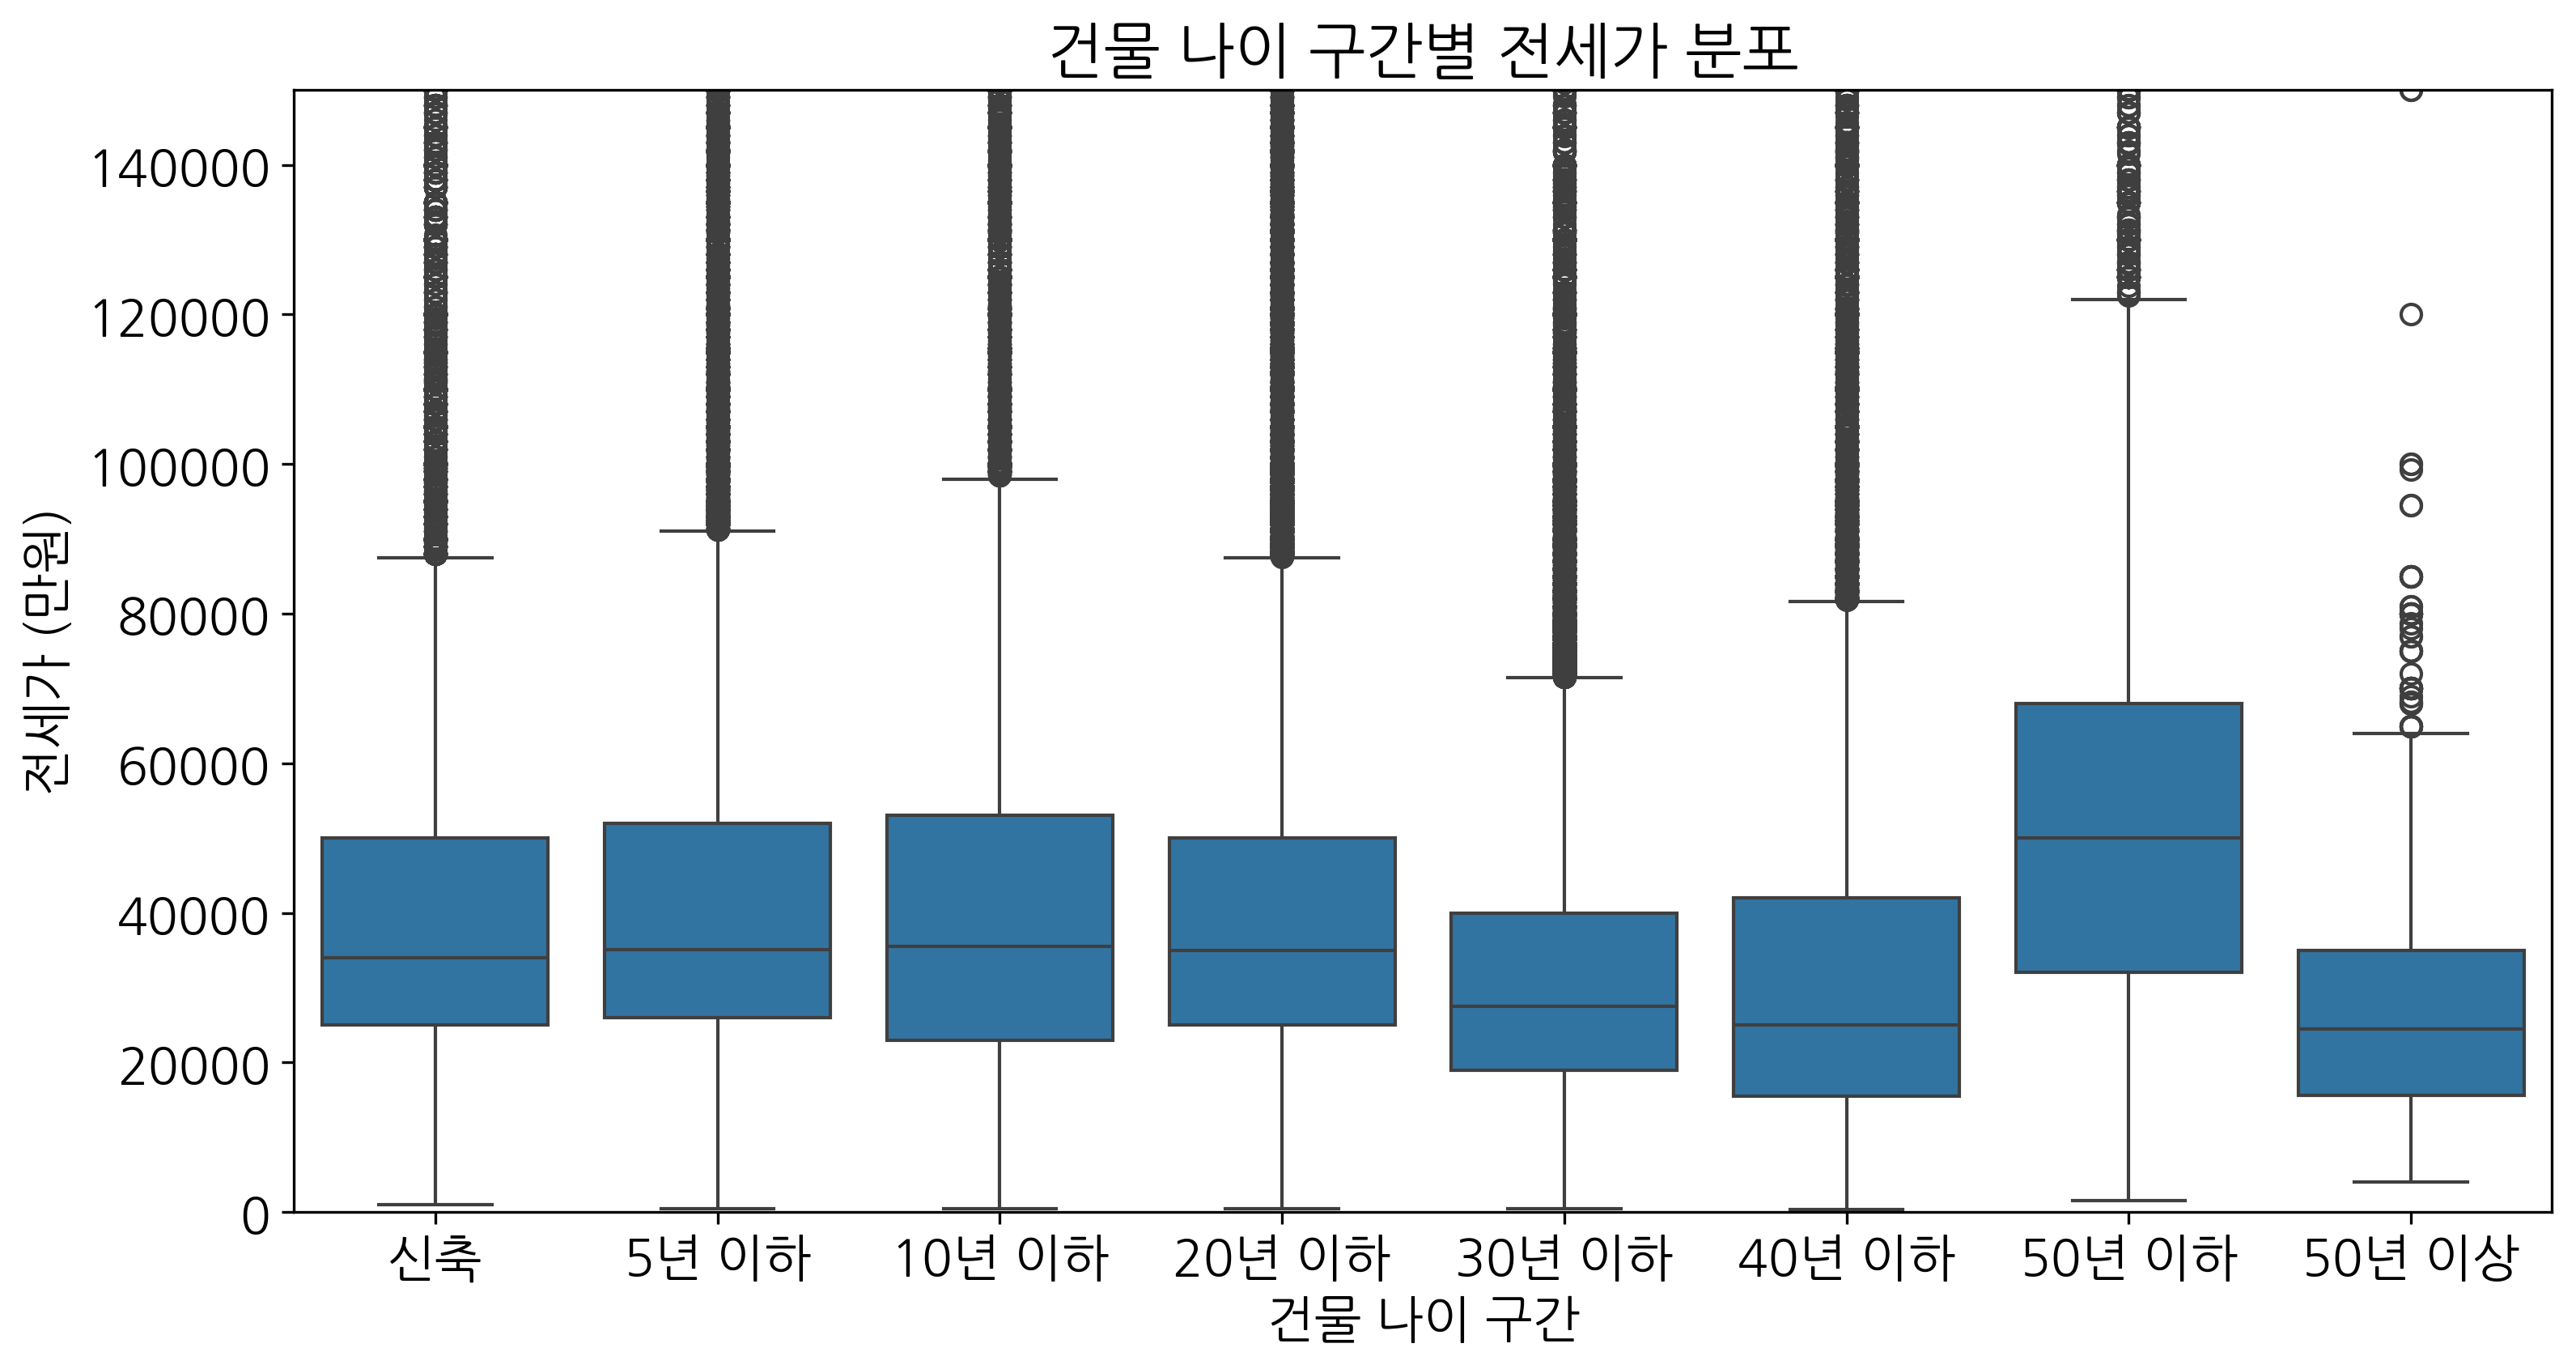

In [88]:
# 나이 구간 생성
df['age_group'] = pd.cut(df['age'], bins=[-5, 0, 5, 10, 20, 30, 40, 50, 100], labels=['신축', '5년 이하', '10년 이하', '20년 이하', '30년 이하', '40년 이하', '50년 이하', '50년 이상'])

# 박스플롯 시각화
plt.figure(figsize=(12, 6), dpi=300)
sns.boxplot(x='age_group', y='deposit', data=df)
plt.title('건물 나이 구간별 전세가 분포')
plt.xlabel('건물 나이 구간')
plt.ylabel('전세가 (만원)')
plt.ylim(0, 150000)
plt.show()

## (5) 계절성과 전세가의 관계:

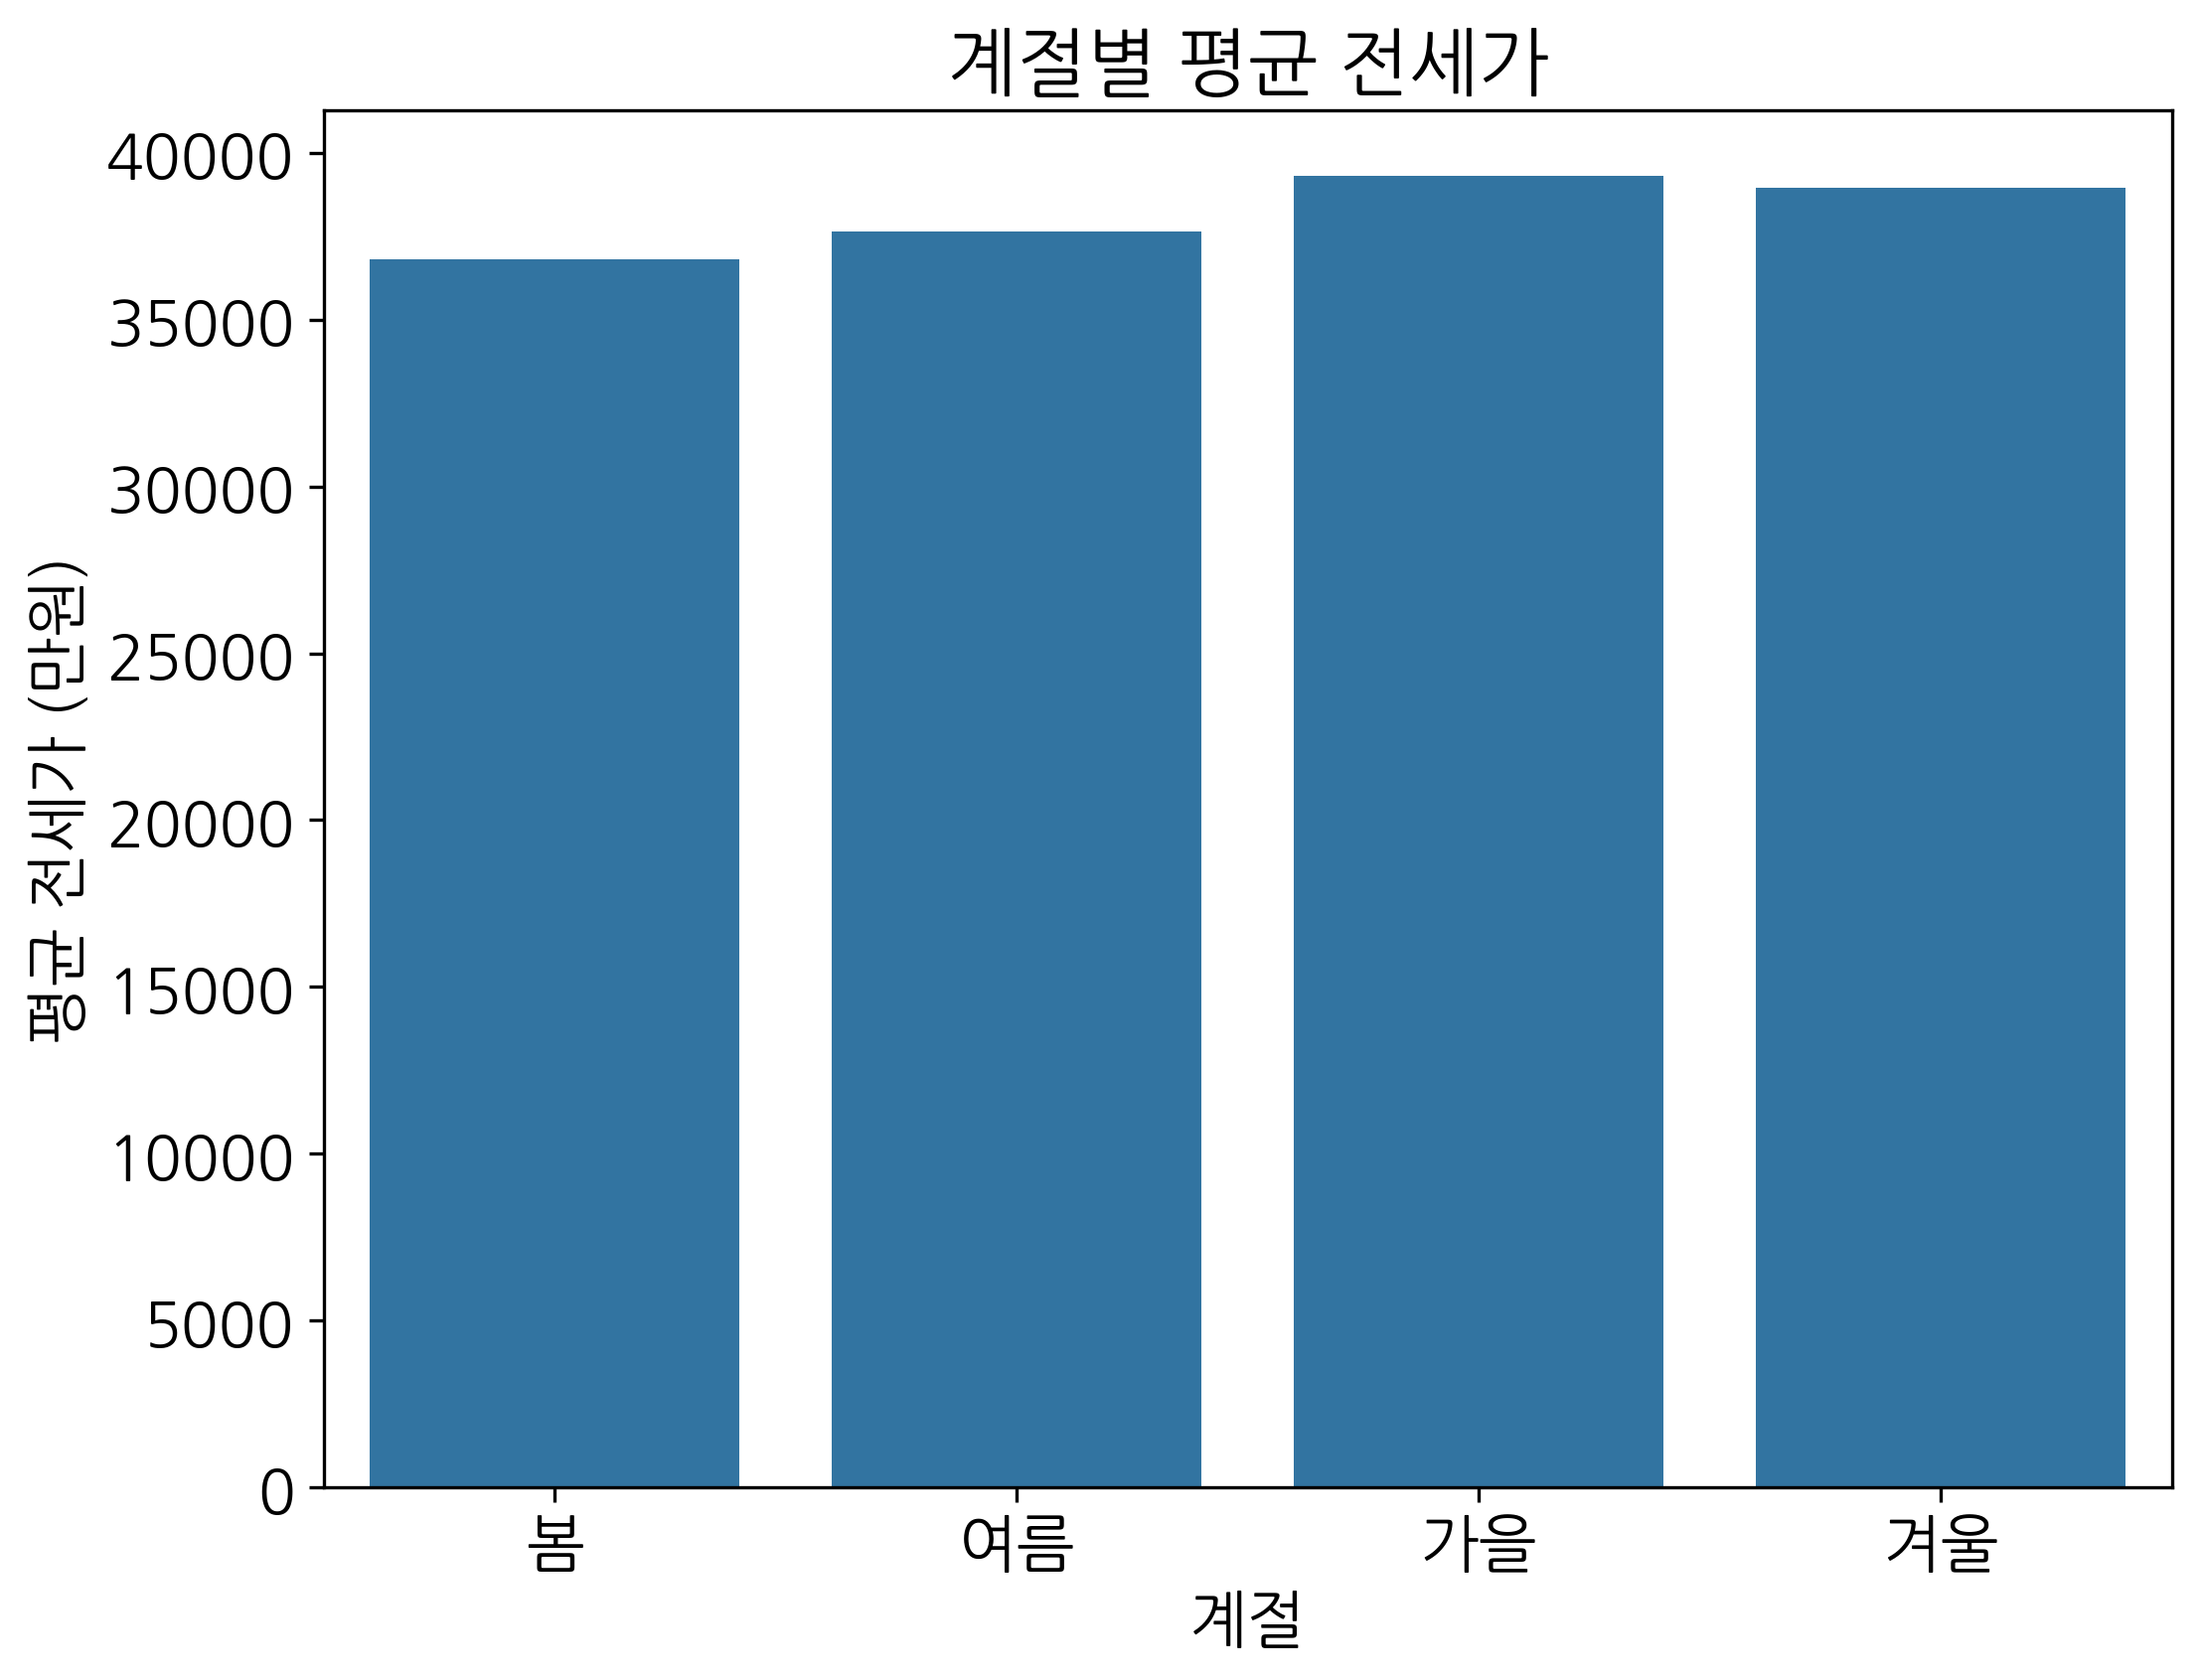

In [89]:
# 계절 매핑
def get_season(month):
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'

df['contract_season'] = df['contract_month'].apply(get_season)

# 계절별 평균 전세가 비교
seasonal_deposit = df.groupby('contract_season')['deposit'].mean().reset_index()

plt.figure(figsize=(8, 6), dpi=300)
sns.barplot(x='contract_season', y='deposit', data=seasonal_deposit, order=['봄', '여름', '가을', '겨울'])
plt.title('계절별 평균 전세가')
plt.xlabel('계절')
plt.ylabel('평균 전세가 (만원)')
plt.show()


In [90]:
gc.collect()

3543

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1951400 entries, 0 to 1951399
Data columns (total 29 columns):
 #   Column                          Dtype   
---  ------                          -----   
 0   index                           int32   
 1   area_m2                         float16 
 2   contract_year_month             int32   
 3   contract_day                    int8    
 4   contract_type                   int8    
 5   floor                           int8    
 6   built_year                      int16   
 7   latitude                        float16 
 8   longitude                       float16 
 9   age                             int8    
 10  deposit                         float32 
 11  _type                           object  
 12  nearest_subway_distance_km      float16 
 13  year_month_date                 object  
 14  interest_rate                   float16 
 15  prev_month_interest_rate        float16 
 16  nearest_elementary_distance_km  float16 
 17  nearest_